In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import lightgbm as lgb
print("Lightgbm version:", lgb.__version__)

import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

Lightgbm version: 4.5.0


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# input parameters
fs_type = 'fsv24'
train_type = "large"

In [4]:
# Parameters
fs_type = "int96"


In [5]:
# Load the feature selection results
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 150
Categorical features: 7
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 222
Categorical Columns: 7


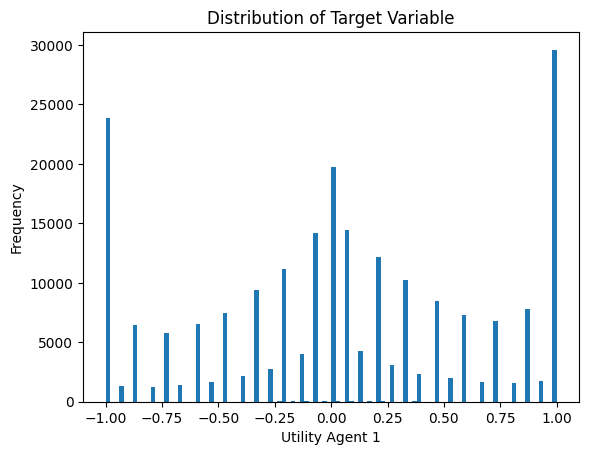

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model


In [9]:
if train_type == "small":
    LEARNING_RATE = 0.08
    NUM_BOOST_ROUND = 2500
elif train_type == "medium":
    LEARNING_RATE = 0.04
    NUM_BOOST_ROUND = 5000
elif train_type == "large":
    LEARNING_RATE = 0.02
    NUM_BOOST_ROUND = 10_000
elif train_type == "xlarge":
    LEARNING_RATE = 0.01
    NUM_BOOST_ROUND = 20_000


print(LEARNING_RATE, NUM_BOOST_ROUND)

0.02 10000


In [10]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters
    params = {
        'objective': "regression",
        'metric': 'rmse',
        'boosting': 'gbdt',
        ###################
        'num_leaves': 31,
        'max_depth': 12,
        'learning_rate': LEARNING_RATE,
        ###################
        'min_data_in_leaf': 100,
        'bagging_freq': 1,
        'bagging_fraction': 0.8,
        'feature_fraction': 0.5,
        'verbose': -1,
        'seed': 2112,
    }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]
        
        # Create LightGBM datasets
        train_data = lgb.Dataset(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )
        val_data = lgb.Dataset(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )

        # Train the model
        model = lgb.train(
            params,
            train_data,
            num_boost_round=NUM_BOOST_ROUND,
            valid_sets=[val_data],
            callbacks=[
                lgb.log_evaluation(period=100),
            ]
        )
        
        # Get feature importance for this fold
        feat_importance = pd.DataFrame({
            'feature': numerical_cols + categorical_cols,
            f'importance_f{fold}': model.feature_importance(importance_type='gain')
        })
        feat_importance_dfs.append(feat_importance)
        
        # Plot feature importance
        lgb.plot_importance(model, figsize=(10, 8), importance_type='gain', max_num_features=50)
        plt.title('Top 50 Features by Importance')
        plt.tight_layout()
        plt.show()
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(X_val[numerical_cols + categorical_cols])

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))
    
    return trained_models, oof, oof_scores, importance_df

Fold 1


[100]	valid_0's rmse: 0.495065


[200]	valid_0's rmse: 0.478477


[300]	valid_0's rmse: 0.468607


[400]	valid_0's rmse: 0.461102


[500]	valid_0's rmse: 0.455249


[600]	valid_0's rmse: 0.451208


[700]	valid_0's rmse: 0.447406


[800]	valid_0's rmse: 0.445105


[900]	valid_0's rmse: 0.442788


[1000]	valid_0's rmse: 0.440922


[1100]	valid_0's rmse: 0.439379


[1200]	valid_0's rmse: 0.438044


[1300]	valid_0's rmse: 0.43693


[1400]	valid_0's rmse: 0.435775


[1500]	valid_0's rmse: 0.434765


[1600]	valid_0's rmse: 0.433915


[1700]	valid_0's rmse: 0.433117


[1800]	valid_0's rmse: 0.43262


[1900]	valid_0's rmse: 0.432029


[2000]	valid_0's rmse: 0.431625


[2100]	valid_0's rmse: 0.431066


[2200]	valid_0's rmse: 0.43057


[2300]	valid_0's rmse: 0.430296


[2400]	valid_0's rmse: 0.429967


[2500]	valid_0's rmse: 0.429623


[2600]	valid_0's rmse: 0.42933


[2700]	valid_0's rmse: 0.429034


[2800]	valid_0's rmse: 0.428873


[2900]	valid_0's rmse: 0.428607


[3000]	valid_0's rmse: 0.428421


[3100]	valid_0's rmse: 0.428153


[3200]	valid_0's rmse: 0.427989


[3300]	valid_0's rmse: 0.427779


[3400]	valid_0's rmse: 0.427532


[3500]	valid_0's rmse: 0.427351


[3600]	valid_0's rmse: 0.427154


[3700]	valid_0's rmse: 0.427014


[3800]	valid_0's rmse: 0.426882


[3900]	valid_0's rmse: 0.426807


[4000]	valid_0's rmse: 0.426623


[4100]	valid_0's rmse: 0.426502


[4200]	valid_0's rmse: 0.426479


[4300]	valid_0's rmse: 0.426362


[4400]	valid_0's rmse: 0.426205


[4500]	valid_0's rmse: 0.426189


[4600]	valid_0's rmse: 0.42604


[4700]	valid_0's rmse: 0.425932


[4800]	valid_0's rmse: 0.425747


[4900]	valid_0's rmse: 0.425646


[5000]	valid_0's rmse: 0.425612


[5100]	valid_0's rmse: 0.425605


[5200]	valid_0's rmse: 0.425453


[5300]	valid_0's rmse: 0.425331


[5400]	valid_0's rmse: 0.42532


[5500]	valid_0's rmse: 0.42524


[5600]	valid_0's rmse: 0.425219


[5700]	valid_0's rmse: 0.425208


[5800]	valid_0's rmse: 0.425084


[5900]	valid_0's rmse: 0.425019


[6000]	valid_0's rmse: 0.424966


[6100]	valid_0's rmse: 0.424849


[6200]	valid_0's rmse: 0.424809


[6300]	valid_0's rmse: 0.424727


[6400]	valid_0's rmse: 0.424718


[6500]	valid_0's rmse: 0.424699


[6600]	valid_0's rmse: 0.424643


[6700]	valid_0's rmse: 0.424584


[6800]	valid_0's rmse: 0.424532


[6900]	valid_0's rmse: 0.424499


[7000]	valid_0's rmse: 0.424502


[7100]	valid_0's rmse: 0.424501


[7200]	valid_0's rmse: 0.424506


[7300]	valid_0's rmse: 0.42447


[7400]	valid_0's rmse: 0.424421


[7500]	valid_0's rmse: 0.424384


[7600]	valid_0's rmse: 0.4244


[7700]	valid_0's rmse: 0.424342


[7800]	valid_0's rmse: 0.424322


[7900]	valid_0's rmse: 0.424257


[8000]	valid_0's rmse: 0.424216


[8100]	valid_0's rmse: 0.424154


[8200]	valid_0's rmse: 0.424194


[8300]	valid_0's rmse: 0.424172


[8400]	valid_0's rmse: 0.424085


[8500]	valid_0's rmse: 0.424043


[8600]	valid_0's rmse: 0.424036


[8700]	valid_0's rmse: 0.424073


[8800]	valid_0's rmse: 0.424064


[8900]	valid_0's rmse: 0.424053


[9000]	valid_0's rmse: 0.424096


[9100]	valid_0's rmse: 0.42409


[9200]	valid_0's rmse: 0.424113


[9300]	valid_0's rmse: 0.424118


[9400]	valid_0's rmse: 0.424085


[9500]	valid_0's rmse: 0.424098


[9600]	valid_0's rmse: 0.424102


[9700]	valid_0's rmse: 0.42408


[9800]	valid_0's rmse: 0.424047


[9900]	valid_0's rmse: 0.423982


[10000]	valid_0's rmse: 0.423994


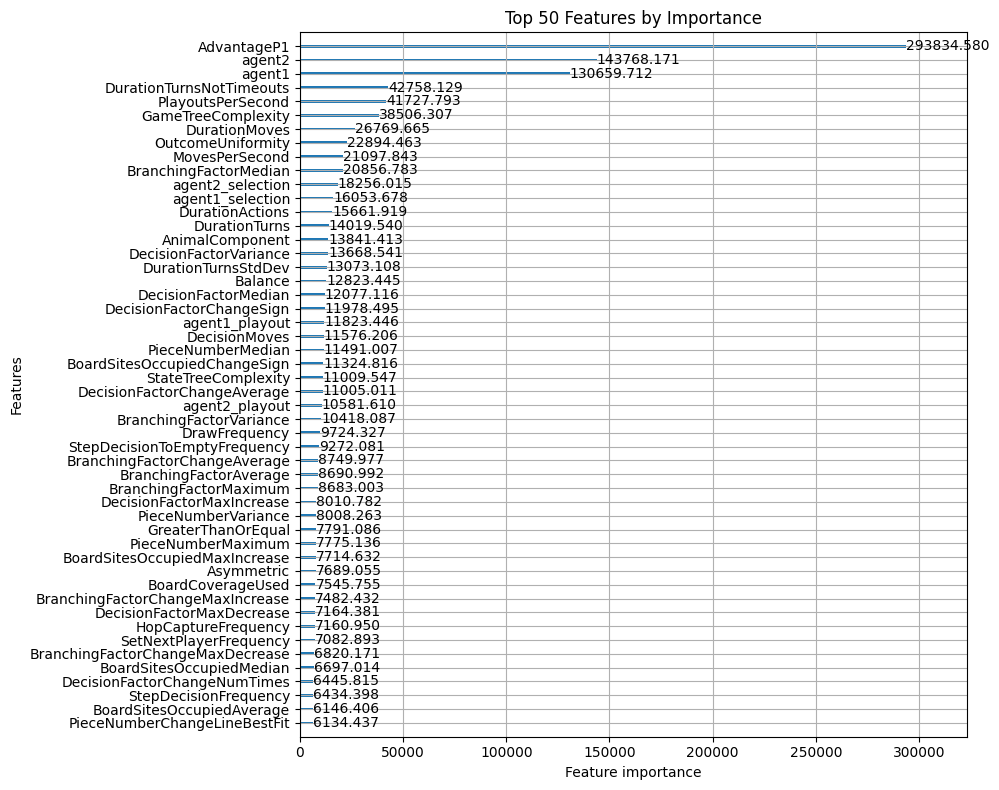

Fold 1 - RMSE: 0.4234503288948624
Fold 2


[100]	valid_0's rmse: 0.507798


[200]	valid_0's rmse: 0.492048


[300]	valid_0's rmse: 0.484266


[400]	valid_0's rmse: 0.478746


[500]	valid_0's rmse: 0.474397


[600]	valid_0's rmse: 0.471238


[700]	valid_0's rmse: 0.468509


[800]	valid_0's rmse: 0.466148


[900]	valid_0's rmse: 0.464699


[1000]	valid_0's rmse: 0.463185


[1100]	valid_0's rmse: 0.462057


[1200]	valid_0's rmse: 0.461054


[1300]	valid_0's rmse: 0.460227


[1400]	valid_0's rmse: 0.459282


[1500]	valid_0's rmse: 0.45856


[1600]	valid_0's rmse: 0.457966


[1700]	valid_0's rmse: 0.457586


[1800]	valid_0's rmse: 0.457072


[1900]	valid_0's rmse: 0.456552


[2000]	valid_0's rmse: 0.455995


[2100]	valid_0's rmse: 0.455586


[2200]	valid_0's rmse: 0.455286


[2300]	valid_0's rmse: 0.454935


[2400]	valid_0's rmse: 0.454753


[2500]	valid_0's rmse: 0.454324


[2600]	valid_0's rmse: 0.453838


[2700]	valid_0's rmse: 0.453533


[2800]	valid_0's rmse: 0.453301


[2900]	valid_0's rmse: 0.453208


[3000]	valid_0's rmse: 0.452956


[3100]	valid_0's rmse: 0.45271


[3200]	valid_0's rmse: 0.452661


[3300]	valid_0's rmse: 0.452497


[3400]	valid_0's rmse: 0.45223


[3500]	valid_0's rmse: 0.451957


[3600]	valid_0's rmse: 0.451703


[3700]	valid_0's rmse: 0.451528


[3800]	valid_0's rmse: 0.451497


[3900]	valid_0's rmse: 0.451332


[4000]	valid_0's rmse: 0.451329


[4100]	valid_0's rmse: 0.451246


[4200]	valid_0's rmse: 0.451098


[4300]	valid_0's rmse: 0.451015


[4400]	valid_0's rmse: 0.450888


[4500]	valid_0's rmse: 0.450725


[4600]	valid_0's rmse: 0.450557


[4700]	valid_0's rmse: 0.450411


[4800]	valid_0's rmse: 0.450394


[4900]	valid_0's rmse: 0.450257


[5000]	valid_0's rmse: 0.450199


[5100]	valid_0's rmse: 0.450134


[5200]	valid_0's rmse: 0.450004


[5300]	valid_0's rmse: 0.449863


[5400]	valid_0's rmse: 0.449764


[5500]	valid_0's rmse: 0.449686


[5600]	valid_0's rmse: 0.449624


[5700]	valid_0's rmse: 0.449569


[5800]	valid_0's rmse: 0.449505


[5900]	valid_0's rmse: 0.449448


[6000]	valid_0's rmse: 0.449352


[6100]	valid_0's rmse: 0.449384


[6200]	valid_0's rmse: 0.449339


[6300]	valid_0's rmse: 0.449282


[6400]	valid_0's rmse: 0.449258


[6500]	valid_0's rmse: 0.449193


[6600]	valid_0's rmse: 0.44915


[6700]	valid_0's rmse: 0.449092


[6800]	valid_0's rmse: 0.449067


[6900]	valid_0's rmse: 0.449088


[7000]	valid_0's rmse: 0.449038


[7100]	valid_0's rmse: 0.448964


[7200]	valid_0's rmse: 0.44891


[7300]	valid_0's rmse: 0.448904


[7400]	valid_0's rmse: 0.448895


[7500]	valid_0's rmse: 0.448938


[7600]	valid_0's rmse: 0.448836


[7700]	valid_0's rmse: 0.448723


[7800]	valid_0's rmse: 0.448641


[7900]	valid_0's rmse: 0.448615


[8000]	valid_0's rmse: 0.448605


[8100]	valid_0's rmse: 0.448604


[8200]	valid_0's rmse: 0.448633


[8300]	valid_0's rmse: 0.44861


[8400]	valid_0's rmse: 0.448642


[8500]	valid_0's rmse: 0.448619


[8600]	valid_0's rmse: 0.448629


[8700]	valid_0's rmse: 0.448568


[8800]	valid_0's rmse: 0.448475


[8900]	valid_0's rmse: 0.448396


[9000]	valid_0's rmse: 0.448399


[9100]	valid_0's rmse: 0.448382


[9200]	valid_0's rmse: 0.448339


[9300]	valid_0's rmse: 0.448292


[9400]	valid_0's rmse: 0.448295


[9500]	valid_0's rmse: 0.4483


[9600]	valid_0's rmse: 0.448215


[9700]	valid_0's rmse: 0.448151


[9800]	valid_0's rmse: 0.448156


[9900]	valid_0's rmse: 0.448105


[10000]	valid_0's rmse: 0.448045


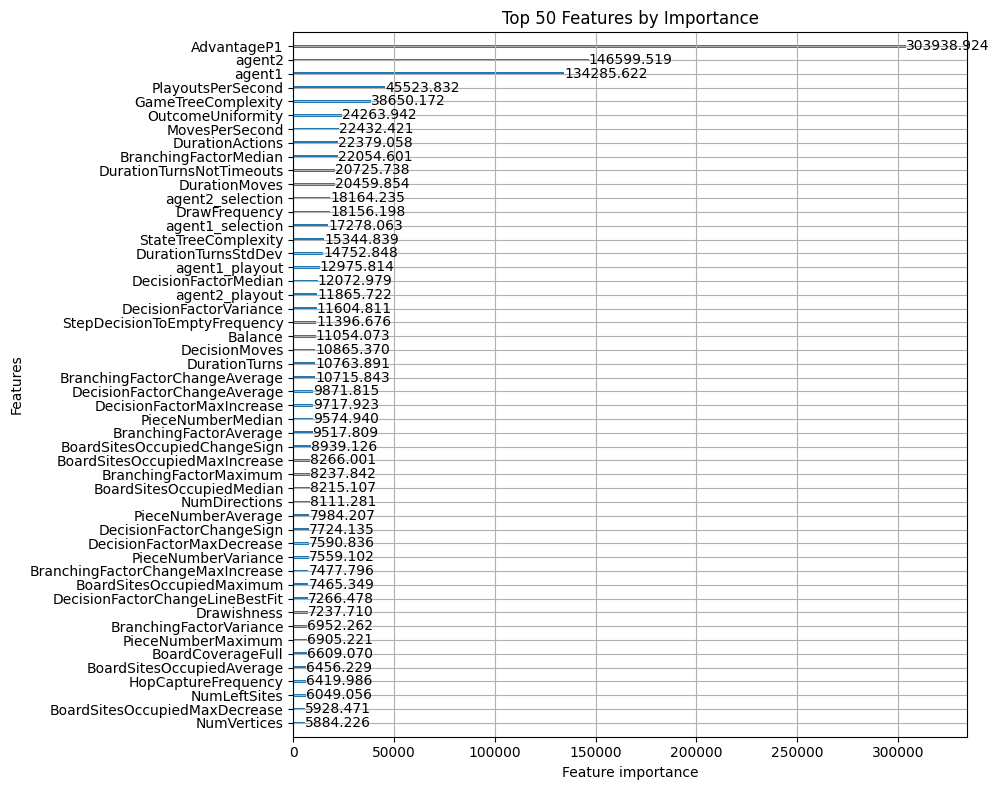

Fold 2 - RMSE: 0.4474101618281032
Fold 3


[100]	valid_0's rmse: 0.513568


[200]	valid_0's rmse: 0.483763


[300]	valid_0's rmse: 0.472657


[400]	valid_0's rmse: 0.466995


[500]	valid_0's rmse: 0.463795


[600]	valid_0's rmse: 0.46036


[700]	valid_0's rmse: 0.45761


[800]	valid_0's rmse: 0.455187


[900]	valid_0's rmse: 0.453523


[1000]	valid_0's rmse: 0.451906


[1100]	valid_0's rmse: 0.450606


[1200]	valid_0's rmse: 0.449528


[1300]	valid_0's rmse: 0.448638


[1400]	valid_0's rmse: 0.448016


[1500]	valid_0's rmse: 0.447265


[1600]	valid_0's rmse: 0.446564


[1700]	valid_0's rmse: 0.446021


[1800]	valid_0's rmse: 0.445617


[1900]	valid_0's rmse: 0.445175


[2000]	valid_0's rmse: 0.444698


[2100]	valid_0's rmse: 0.444325


[2200]	valid_0's rmse: 0.444024


[2300]	valid_0's rmse: 0.44378


[2400]	valid_0's rmse: 0.443539


[2500]	valid_0's rmse: 0.443165


[2600]	valid_0's rmse: 0.44287


[2700]	valid_0's rmse: 0.442689


[2800]	valid_0's rmse: 0.442429


[2900]	valid_0's rmse: 0.442207


[3000]	valid_0's rmse: 0.441979


[3100]	valid_0's rmse: 0.441921


[3200]	valid_0's rmse: 0.441639


[3300]	valid_0's rmse: 0.441434


[3400]	valid_0's rmse: 0.441251


[3500]	valid_0's rmse: 0.441054


[3600]	valid_0's rmse: 0.440965


[3700]	valid_0's rmse: 0.440766


[3800]	valid_0's rmse: 0.440686


[3900]	valid_0's rmse: 0.440523


[4000]	valid_0's rmse: 0.440335


[4100]	valid_0's rmse: 0.440145


[4200]	valid_0's rmse: 0.440052


[4300]	valid_0's rmse: 0.439969


[4400]	valid_0's rmse: 0.439894


[4500]	valid_0's rmse: 0.439813


[4600]	valid_0's rmse: 0.439719


[4700]	valid_0's rmse: 0.439577


[4800]	valid_0's rmse: 0.43953


[4900]	valid_0's rmse: 0.439435


[5000]	valid_0's rmse: 0.439353


[5100]	valid_0's rmse: 0.439184


[5200]	valid_0's rmse: 0.439133


[5300]	valid_0's rmse: 0.438995


[5400]	valid_0's rmse: 0.438971


[5500]	valid_0's rmse: 0.438923


[5600]	valid_0's rmse: 0.43886


[5700]	valid_0's rmse: 0.438726


[5800]	valid_0's rmse: 0.438703


[5900]	valid_0's rmse: 0.438697


[6000]	valid_0's rmse: 0.438601


[6100]	valid_0's rmse: 0.438556


[6200]	valid_0's rmse: 0.438531


[6300]	valid_0's rmse: 0.438528


[6400]	valid_0's rmse: 0.438515


[6500]	valid_0's rmse: 0.438499


[6600]	valid_0's rmse: 0.438501


[6700]	valid_0's rmse: 0.438395


[6800]	valid_0's rmse: 0.43836


[6900]	valid_0's rmse: 0.438302


[7000]	valid_0's rmse: 0.438267


[7100]	valid_0's rmse: 0.438258


[7200]	valid_0's rmse: 0.438185


[7300]	valid_0's rmse: 0.438123


[7400]	valid_0's rmse: 0.438114


[7500]	valid_0's rmse: 0.438072


[7600]	valid_0's rmse: 0.438105


[7700]	valid_0's rmse: 0.438037


[7800]	valid_0's rmse: 0.437974


[7900]	valid_0's rmse: 0.437978


[8000]	valid_0's rmse: 0.437917


[8100]	valid_0's rmse: 0.437848


[8200]	valid_0's rmse: 0.437877


[8300]	valid_0's rmse: 0.437781


[8400]	valid_0's rmse: 0.437787


[8500]	valid_0's rmse: 0.437723


[8600]	valid_0's rmse: 0.437709


[8700]	valid_0's rmse: 0.437734


[8800]	valid_0's rmse: 0.437722


[8900]	valid_0's rmse: 0.437665


[9000]	valid_0's rmse: 0.437639


[9100]	valid_0's rmse: 0.437638


[9200]	valid_0's rmse: 0.43761


[9300]	valid_0's rmse: 0.437639


[9400]	valid_0's rmse: 0.437625


[9500]	valid_0's rmse: 0.43759


[9600]	valid_0's rmse: 0.437598


[9700]	valid_0's rmse: 0.437694


[9800]	valid_0's rmse: 0.437666


[9900]	valid_0's rmse: 0.437603


[10000]	valid_0's rmse: 0.437628


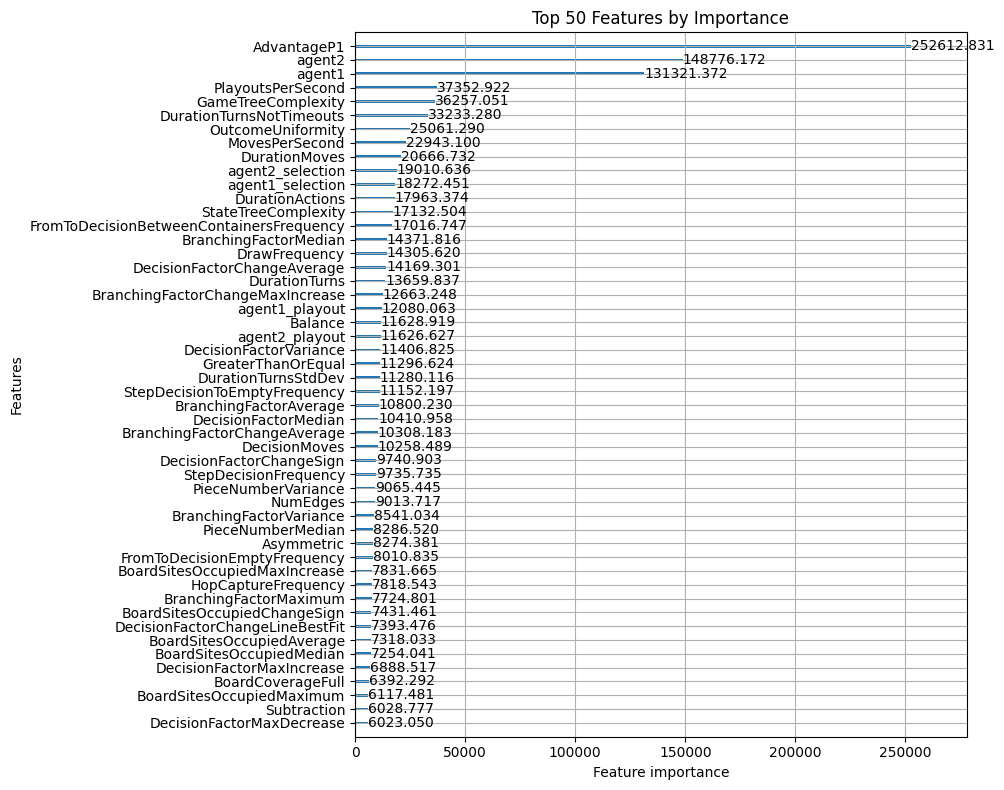

Fold 3 - RMSE: 0.4369219579577372
Fold 4


[100]	valid_0's rmse: 0.513047


[200]	valid_0's rmse: 0.491804


[300]	valid_0's rmse: 0.479722


[400]	valid_0's rmse: 0.472556


[500]	valid_0's rmse: 0.466956


[600]	valid_0's rmse: 0.462661


[700]	valid_0's rmse: 0.460059


[800]	valid_0's rmse: 0.457557


[900]	valid_0's rmse: 0.455654


[1000]	valid_0's rmse: 0.454061


[1100]	valid_0's rmse: 0.452808


[1200]	valid_0's rmse: 0.451488


[1300]	valid_0's rmse: 0.450498


[1400]	valid_0's rmse: 0.449485


[1500]	valid_0's rmse: 0.448743


[1600]	valid_0's rmse: 0.448034


[1700]	valid_0's rmse: 0.44744


[1800]	valid_0's rmse: 0.446779


[1900]	valid_0's rmse: 0.446169


[2000]	valid_0's rmse: 0.445716


[2100]	valid_0's rmse: 0.445098


[2200]	valid_0's rmse: 0.444707


[2300]	valid_0's rmse: 0.444435


[2400]	valid_0's rmse: 0.443995


[2500]	valid_0's rmse: 0.443693


[2600]	valid_0's rmse: 0.443337


[2700]	valid_0's rmse: 0.443072


[2800]	valid_0's rmse: 0.442805


[2900]	valid_0's rmse: 0.442688


[3000]	valid_0's rmse: 0.442361


[3100]	valid_0's rmse: 0.442126


[3200]	valid_0's rmse: 0.442019


[3300]	valid_0's rmse: 0.441869


[3400]	valid_0's rmse: 0.441756


[3500]	valid_0's rmse: 0.441544


[3600]	valid_0's rmse: 0.441387


[3700]	valid_0's rmse: 0.441251


[3800]	valid_0's rmse: 0.441073


[3900]	valid_0's rmse: 0.44081


[4000]	valid_0's rmse: 0.440609


[4100]	valid_0's rmse: 0.440407


[4200]	valid_0's rmse: 0.440305


[4300]	valid_0's rmse: 0.440164


[4400]	valid_0's rmse: 0.439999


[4500]	valid_0's rmse: 0.439878


[4600]	valid_0's rmse: 0.439698


[4700]	valid_0's rmse: 0.439553


[4800]	valid_0's rmse: 0.439382


[4900]	valid_0's rmse: 0.439377


[5000]	valid_0's rmse: 0.439344


[5100]	valid_0's rmse: 0.439234


[5200]	valid_0's rmse: 0.43922


[5300]	valid_0's rmse: 0.43909


[5400]	valid_0's rmse: 0.439036


[5500]	valid_0's rmse: 0.438944


[5600]	valid_0's rmse: 0.438897


[5700]	valid_0's rmse: 0.438918


[5800]	valid_0's rmse: 0.438908


[5900]	valid_0's rmse: 0.438841


[6000]	valid_0's rmse: 0.438752


[6100]	valid_0's rmse: 0.438664


[6200]	valid_0's rmse: 0.438638


[6300]	valid_0's rmse: 0.43863


[6400]	valid_0's rmse: 0.438542


[6500]	valid_0's rmse: 0.438456


[6600]	valid_0's rmse: 0.438397


[6700]	valid_0's rmse: 0.438341


[6800]	valid_0's rmse: 0.438295


[6900]	valid_0's rmse: 0.438204


[7000]	valid_0's rmse: 0.43818


[7100]	valid_0's rmse: 0.438108


[7200]	valid_0's rmse: 0.438083


[7300]	valid_0's rmse: 0.43799


[7400]	valid_0's rmse: 0.437973


[7500]	valid_0's rmse: 0.437971


[7600]	valid_0's rmse: 0.437926


[7700]	valid_0's rmse: 0.437918


[7800]	valid_0's rmse: 0.437901


[7900]	valid_0's rmse: 0.437833


[8000]	valid_0's rmse: 0.437781


[8100]	valid_0's rmse: 0.437737


[8200]	valid_0's rmse: 0.43759


[8300]	valid_0's rmse: 0.437548


[8400]	valid_0's rmse: 0.43751


[8500]	valid_0's rmse: 0.437469


[8600]	valid_0's rmse: 0.437475


[8700]	valid_0's rmse: 0.437374


[8800]	valid_0's rmse: 0.437315


[8900]	valid_0's rmse: 0.437294


[9000]	valid_0's rmse: 0.437308


[9100]	valid_0's rmse: 0.437254


[9200]	valid_0's rmse: 0.437212


[9300]	valid_0's rmse: 0.437171


[9400]	valid_0's rmse: 0.437072


[9500]	valid_0's rmse: 0.437033


[9600]	valid_0's rmse: 0.437005


[9700]	valid_0's rmse: 0.43697


[9800]	valid_0's rmse: 0.436948


[9900]	valid_0's rmse: 0.43693


[10000]	valid_0's rmse: 0.436976


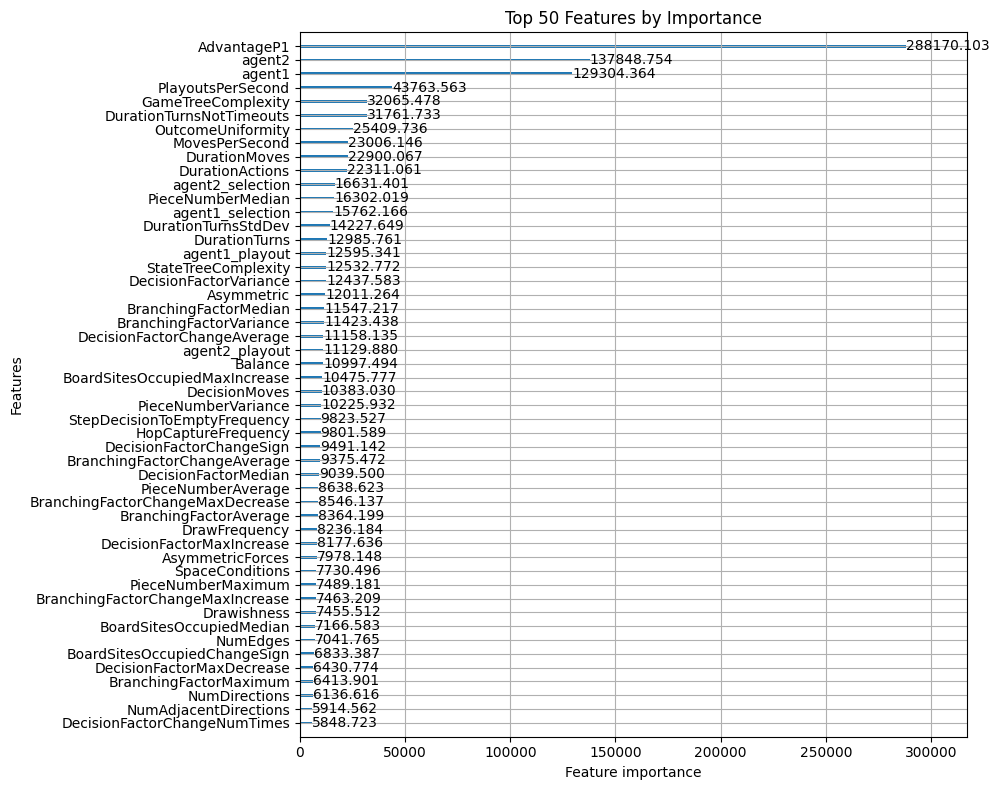

Fold 4 - RMSE: 0.4360237443955416
Fold 5


[100]	valid_0's rmse: 0.486872


[200]	valid_0's rmse: 0.467591


[300]	valid_0's rmse: 0.454925


[400]	valid_0's rmse: 0.446052


[500]	valid_0's rmse: 0.439121


[600]	valid_0's rmse: 0.434602


[700]	valid_0's rmse: 0.430689


[800]	valid_0's rmse: 0.427505


[900]	valid_0's rmse: 0.425128


[1000]	valid_0's rmse: 0.423357


[1100]	valid_0's rmse: 0.421329


[1200]	valid_0's rmse: 0.420028


[1300]	valid_0's rmse: 0.418972


[1400]	valid_0's rmse: 0.417909


[1500]	valid_0's rmse: 0.417046


[1600]	valid_0's rmse: 0.416145


[1700]	valid_0's rmse: 0.415512


[1800]	valid_0's rmse: 0.414863


[1900]	valid_0's rmse: 0.414264


[2000]	valid_0's rmse: 0.413738


[2100]	valid_0's rmse: 0.413271


[2200]	valid_0's rmse: 0.412885


[2300]	valid_0's rmse: 0.412485


[2400]	valid_0's rmse: 0.411987


[2500]	valid_0's rmse: 0.41162


[2600]	valid_0's rmse: 0.411299


[2700]	valid_0's rmse: 0.410989


[2800]	valid_0's rmse: 0.410704


[2900]	valid_0's rmse: 0.410499


[3000]	valid_0's rmse: 0.41019


[3100]	valid_0's rmse: 0.409985


[3200]	valid_0's rmse: 0.409849


[3300]	valid_0's rmse: 0.409722


[3400]	valid_0's rmse: 0.409539


[3500]	valid_0's rmse: 0.409432


[3600]	valid_0's rmse: 0.40932


[3700]	valid_0's rmse: 0.409135


[3800]	valid_0's rmse: 0.408877


[3900]	valid_0's rmse: 0.40873


[4000]	valid_0's rmse: 0.408517


[4100]	valid_0's rmse: 0.408428


[4200]	valid_0's rmse: 0.408414


[4300]	valid_0's rmse: 0.408277


[4400]	valid_0's rmse: 0.408191


[4500]	valid_0's rmse: 0.408038


[4600]	valid_0's rmse: 0.407896


[4700]	valid_0's rmse: 0.407817


[4800]	valid_0's rmse: 0.4078


[4900]	valid_0's rmse: 0.407709


[5000]	valid_0's rmse: 0.407666


[5100]	valid_0's rmse: 0.407631


[5200]	valid_0's rmse: 0.407556


[5300]	valid_0's rmse: 0.407411


[5400]	valid_0's rmse: 0.407422


[5500]	valid_0's rmse: 0.407441


[5600]	valid_0's rmse: 0.407429


[5700]	valid_0's rmse: 0.407407


[5800]	valid_0's rmse: 0.407384


[5900]	valid_0's rmse: 0.407355


[6000]	valid_0's rmse: 0.407271


[6100]	valid_0's rmse: 0.407248


[6200]	valid_0's rmse: 0.407197


[6300]	valid_0's rmse: 0.407151


[6400]	valid_0's rmse: 0.407056


[6500]	valid_0's rmse: 0.406991


[6600]	valid_0's rmse: 0.40695


[6700]	valid_0's rmse: 0.406941


[6800]	valid_0's rmse: 0.406905


[6900]	valid_0's rmse: 0.406844


[7000]	valid_0's rmse: 0.40681


[7100]	valid_0's rmse: 0.406737


[7200]	valid_0's rmse: 0.406717


[7300]	valid_0's rmse: 0.406646


[7400]	valid_0's rmse: 0.406686


[7500]	valid_0's rmse: 0.406717


[7600]	valid_0's rmse: 0.406697


[7700]	valid_0's rmse: 0.40665


[7800]	valid_0's rmse: 0.40669


[7900]	valid_0's rmse: 0.406632


[8000]	valid_0's rmse: 0.406598


[8100]	valid_0's rmse: 0.406575


[8200]	valid_0's rmse: 0.406571


[8300]	valid_0's rmse: 0.406605


[8400]	valid_0's rmse: 0.406613


[8500]	valid_0's rmse: 0.406563


[8600]	valid_0's rmse: 0.406546


[8700]	valid_0's rmse: 0.406558


[8800]	valid_0's rmse: 0.406586


[8900]	valid_0's rmse: 0.406587


[9000]	valid_0's rmse: 0.406598


[9100]	valid_0's rmse: 0.406573


[9200]	valid_0's rmse: 0.406548


[9300]	valid_0's rmse: 0.40655


[9400]	valid_0's rmse: 0.406544


[9500]	valid_0's rmse: 0.406537


[9600]	valid_0's rmse: 0.4065


[9700]	valid_0's rmse: 0.406488


[9800]	valid_0's rmse: 0.406509


[9900]	valid_0's rmse: 0.406494


[10000]	valid_0's rmse: 0.406526


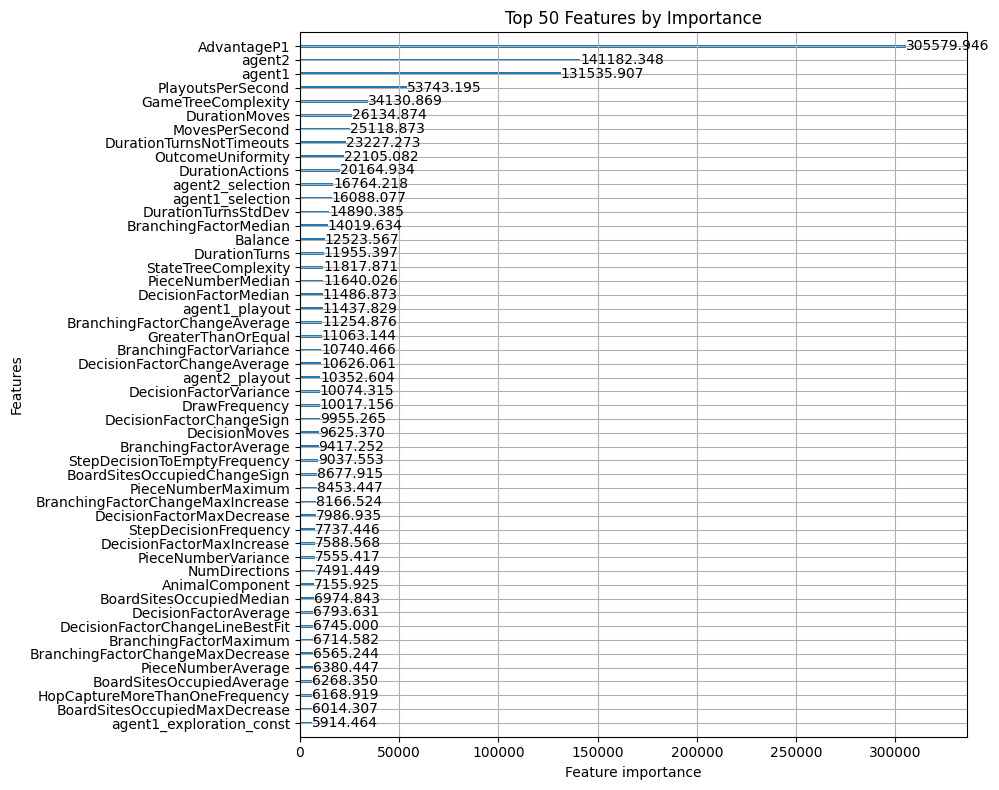

Fold 5 - RMSE: 0.40613762861201963
List of oof scores: [0.4234503288948624, 0.4474101618281032, 0.4369219579577372, 0.4360237443955416, 0.40613762861201963]
Average oof score: 0.4299887643376528


In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv1.parquet', index=False)

Fold 1


[100]	valid_0's rmse: 0.479073


[200]	valid_0's rmse: 0.458889


[300]	valid_0's rmse: 0.448245


[400]	valid_0's rmse: 0.442231


[500]	valid_0's rmse: 0.436996


[600]	valid_0's rmse: 0.433967


[700]	valid_0's rmse: 0.431523


[800]	valid_0's rmse: 0.429126


[900]	valid_0's rmse: 0.427135


[1000]	valid_0's rmse: 0.425801


[1100]	valid_0's rmse: 0.424747


[1200]	valid_0's rmse: 0.423719


[1300]	valid_0's rmse: 0.422687


[1400]	valid_0's rmse: 0.421894


[1500]	valid_0's rmse: 0.421032


[1600]	valid_0's rmse: 0.420218


[1700]	valid_0's rmse: 0.419735


[1800]	valid_0's rmse: 0.419209


[1900]	valid_0's rmse: 0.418733


[2000]	valid_0's rmse: 0.418159


[2100]	valid_0's rmse: 0.417635


[2200]	valid_0's rmse: 0.41723


[2300]	valid_0's rmse: 0.416898


[2400]	valid_0's rmse: 0.416473


[2500]	valid_0's rmse: 0.415994


[2600]	valid_0's rmse: 0.415675


[2700]	valid_0's rmse: 0.415439


[2800]	valid_0's rmse: 0.415258


[2900]	valid_0's rmse: 0.41493


[3000]	valid_0's rmse: 0.414823


[3100]	valid_0's rmse: 0.414699


[3200]	valid_0's rmse: 0.414492


[3300]	valid_0's rmse: 0.414289


[3400]	valid_0's rmse: 0.414078


[3500]	valid_0's rmse: 0.41399


[3600]	valid_0's rmse: 0.413895


[3700]	valid_0's rmse: 0.413749


[3800]	valid_0's rmse: 0.413601


[3900]	valid_0's rmse: 0.413476


[4000]	valid_0's rmse: 0.413272


[4100]	valid_0's rmse: 0.413075


[4200]	valid_0's rmse: 0.413039


[4300]	valid_0's rmse: 0.412933


[4400]	valid_0's rmse: 0.412799


[4500]	valid_0's rmse: 0.412626


[4600]	valid_0's rmse: 0.412428


[4700]	valid_0's rmse: 0.412297


[4800]	valid_0's rmse: 0.412217


[4900]	valid_0's rmse: 0.412129


[5000]	valid_0's rmse: 0.412038


[5100]	valid_0's rmse: 0.411952


[5200]	valid_0's rmse: 0.411753


[5300]	valid_0's rmse: 0.411646


[5400]	valid_0's rmse: 0.41142


[5500]	valid_0's rmse: 0.411425


[5600]	valid_0's rmse: 0.411334


[5700]	valid_0's rmse: 0.411249


[5800]	valid_0's rmse: 0.411237


[5900]	valid_0's rmse: 0.411165


[6000]	valid_0's rmse: 0.411083


[6100]	valid_0's rmse: 0.410999


[6200]	valid_0's rmse: 0.410931


[6300]	valid_0's rmse: 0.410863


[6400]	valid_0's rmse: 0.410793


[6500]	valid_0's rmse: 0.410808


[6600]	valid_0's rmse: 0.410774


[6700]	valid_0's rmse: 0.410669


[6800]	valid_0's rmse: 0.410672


[6900]	valid_0's rmse: 0.410574


[7000]	valid_0's rmse: 0.410521


[7100]	valid_0's rmse: 0.410512


[7200]	valid_0's rmse: 0.41048


[7300]	valid_0's rmse: 0.410406


[7400]	valid_0's rmse: 0.410401


[7500]	valid_0's rmse: 0.410377


[7600]	valid_0's rmse: 0.41033


[7700]	valid_0's rmse: 0.410306


[7800]	valid_0's rmse: 0.410267


[7900]	valid_0's rmse: 0.410256


[8000]	valid_0's rmse: 0.410281


[8100]	valid_0's rmse: 0.410269


[8200]	valid_0's rmse: 0.410262


[8300]	valid_0's rmse: 0.410262


[8400]	valid_0's rmse: 0.410198


[8500]	valid_0's rmse: 0.410228


[8600]	valid_0's rmse: 0.410172


[8700]	valid_0's rmse: 0.410175


[8800]	valid_0's rmse: 0.410143


[8900]	valid_0's rmse: 0.410121


[9000]	valid_0's rmse: 0.410052


[9100]	valid_0's rmse: 0.410016


[9200]	valid_0's rmse: 0.409953


[9300]	valid_0's rmse: 0.409872


[9400]	valid_0's rmse: 0.409866


[9500]	valid_0's rmse: 0.409895


[9600]	valid_0's rmse: 0.409879


[9700]	valid_0's rmse: 0.409835


[9800]	valid_0's rmse: 0.4098


[9900]	valid_0's rmse: 0.409779


[10000]	valid_0's rmse: 0.409798


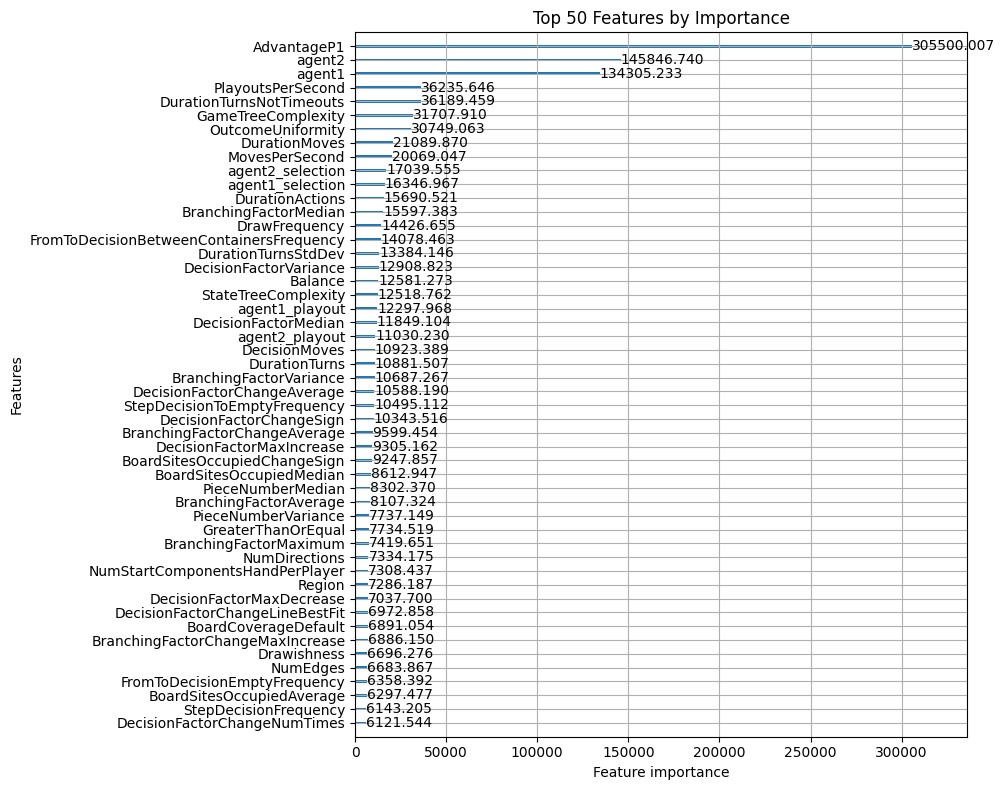

Fold 1 - RMSE: 0.4093184258270123
Fold 2


[100]	valid_0's rmse: 0.459835


[200]	valid_0's rmse: 0.439809


[300]	valid_0's rmse: 0.430292


[400]	valid_0's rmse: 0.424488


[500]	valid_0's rmse: 0.421487


[600]	valid_0's rmse: 0.418712


[700]	valid_0's rmse: 0.416402


[800]	valid_0's rmse: 0.4143


[900]	valid_0's rmse: 0.412922


[1000]	valid_0's rmse: 0.411775


[1100]	valid_0's rmse: 0.410609


[1200]	valid_0's rmse: 0.409688


[1300]	valid_0's rmse: 0.409132


[1400]	valid_0's rmse: 0.408688


[1500]	valid_0's rmse: 0.408248


[1600]	valid_0's rmse: 0.407758


[1700]	valid_0's rmse: 0.407318


[1800]	valid_0's rmse: 0.406856


[1900]	valid_0's rmse: 0.406552


[2000]	valid_0's rmse: 0.406156


[2100]	valid_0's rmse: 0.405861


[2200]	valid_0's rmse: 0.405505


[2300]	valid_0's rmse: 0.405208


[2400]	valid_0's rmse: 0.405088


[2500]	valid_0's rmse: 0.404862


[2600]	valid_0's rmse: 0.404584


[2700]	valid_0's rmse: 0.404366


[2800]	valid_0's rmse: 0.404241


[2900]	valid_0's rmse: 0.404101


[3000]	valid_0's rmse: 0.403954


[3100]	valid_0's rmse: 0.40386


[3200]	valid_0's rmse: 0.403743


[3300]	valid_0's rmse: 0.40361


[3400]	valid_0's rmse: 0.40344


[3500]	valid_0's rmse: 0.403245


[3600]	valid_0's rmse: 0.403188


[3700]	valid_0's rmse: 0.403004


[3800]	valid_0's rmse: 0.403053


[3900]	valid_0's rmse: 0.402878


[4000]	valid_0's rmse: 0.402794


[4100]	valid_0's rmse: 0.402746


[4200]	valid_0's rmse: 0.402557


[4300]	valid_0's rmse: 0.402596


[4400]	valid_0's rmse: 0.402633


[4500]	valid_0's rmse: 0.402569


[4600]	valid_0's rmse: 0.402582


[4700]	valid_0's rmse: 0.402525


[4800]	valid_0's rmse: 0.402455


[4900]	valid_0's rmse: 0.402437


[5000]	valid_0's rmse: 0.402336


[5100]	valid_0's rmse: 0.402327


[5200]	valid_0's rmse: 0.402229


[5300]	valid_0's rmse: 0.402238


[5400]	valid_0's rmse: 0.402193


[5500]	valid_0's rmse: 0.402147


[5600]	valid_0's rmse: 0.402189


[5700]	valid_0's rmse: 0.40209


[5800]	valid_0's rmse: 0.402029


[5900]	valid_0's rmse: 0.401976


[6000]	valid_0's rmse: 0.401977


[6100]	valid_0's rmse: 0.401954


[6200]	valid_0's rmse: 0.401873


[6300]	valid_0's rmse: 0.401887


[6400]	valid_0's rmse: 0.401864


[6500]	valid_0's rmse: 0.401842


[6600]	valid_0's rmse: 0.401862


[6700]	valid_0's rmse: 0.401802


[6800]	valid_0's rmse: 0.401796


[6900]	valid_0's rmse: 0.401766


[7000]	valid_0's rmse: 0.401772


[7100]	valid_0's rmse: 0.401758


[7200]	valid_0's rmse: 0.401745


[7300]	valid_0's rmse: 0.401741


[7400]	valid_0's rmse: 0.401689


[7500]	valid_0's rmse: 0.401669


[7600]	valid_0's rmse: 0.401634


[7700]	valid_0's rmse: 0.401672


[7800]	valid_0's rmse: 0.401684


[7900]	valid_0's rmse: 0.401697


[8000]	valid_0's rmse: 0.40167


[8100]	valid_0's rmse: 0.401717


[8200]	valid_0's rmse: 0.401722


[8300]	valid_0's rmse: 0.401696


[8400]	valid_0's rmse: 0.401699


[8500]	valid_0's rmse: 0.401683


[8600]	valid_0's rmse: 0.401748


[8700]	valid_0's rmse: 0.401746


[8800]	valid_0's rmse: 0.401756


[8900]	valid_0's rmse: 0.401747


[9000]	valid_0's rmse: 0.401757


[9100]	valid_0's rmse: 0.401802


[9200]	valid_0's rmse: 0.401892


[9300]	valid_0's rmse: 0.401905


[9400]	valid_0's rmse: 0.401864


[9500]	valid_0's rmse: 0.401876


[9600]	valid_0's rmse: 0.401888


[9700]	valid_0's rmse: 0.40184


[9800]	valid_0's rmse: 0.401815


[9900]	valid_0's rmse: 0.401825


[10000]	valid_0's rmse: 0.401817


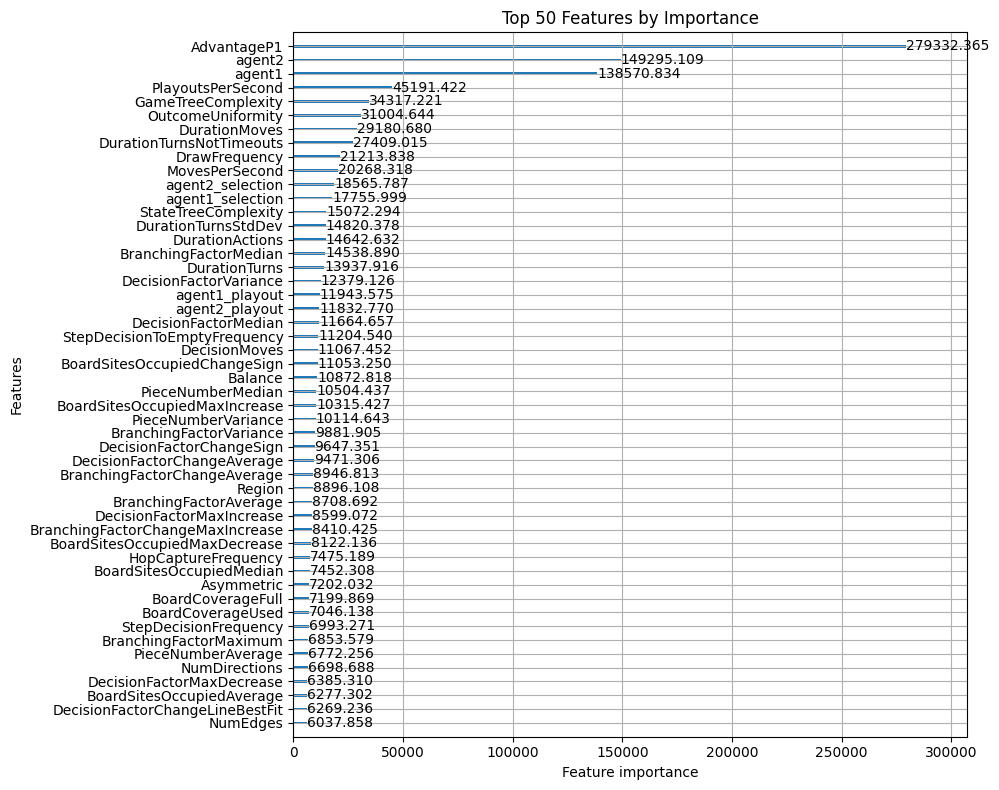

Fold 2 - RMSE: 0.4011772206552318
Fold 3


[100]	valid_0's rmse: 0.525192


[200]	valid_0's rmse: 0.498599


[300]	valid_0's rmse: 0.483931


[400]	valid_0's rmse: 0.474997


[500]	valid_0's rmse: 0.469026


[600]	valid_0's rmse: 0.464005


[700]	valid_0's rmse: 0.460787


[800]	valid_0's rmse: 0.457737


[900]	valid_0's rmse: 0.455285


[1000]	valid_0's rmse: 0.453164


[1100]	valid_0's rmse: 0.451319


[1200]	valid_0's rmse: 0.449699


[1300]	valid_0's rmse: 0.448512


[1400]	valid_0's rmse: 0.44737


[1500]	valid_0's rmse: 0.446489


[1600]	valid_0's rmse: 0.445921


[1700]	valid_0's rmse: 0.445122


[1800]	valid_0's rmse: 0.444483


[1900]	valid_0's rmse: 0.443933


[2000]	valid_0's rmse: 0.443296


[2100]	valid_0's rmse: 0.44264


[2200]	valid_0's rmse: 0.442211


[2300]	valid_0's rmse: 0.441729


[2400]	valid_0's rmse: 0.441202


[2500]	valid_0's rmse: 0.440868


[2600]	valid_0's rmse: 0.440434


[2700]	valid_0's rmse: 0.440053


[2800]	valid_0's rmse: 0.439816


[2900]	valid_0's rmse: 0.439518


[3000]	valid_0's rmse: 0.439194


[3100]	valid_0's rmse: 0.43903


[3200]	valid_0's rmse: 0.438783


[3300]	valid_0's rmse: 0.438557


[3400]	valid_0's rmse: 0.438299


[3500]	valid_0's rmse: 0.438025


[3600]	valid_0's rmse: 0.4377


[3700]	valid_0's rmse: 0.437447


[3800]	valid_0's rmse: 0.437191


[3900]	valid_0's rmse: 0.436996


[4000]	valid_0's rmse: 0.436886


[4100]	valid_0's rmse: 0.436808


[4200]	valid_0's rmse: 0.436679


[4300]	valid_0's rmse: 0.436479


[4400]	valid_0's rmse: 0.436319


[4500]	valid_0's rmse: 0.436239


[4600]	valid_0's rmse: 0.436088


[4700]	valid_0's rmse: 0.436055


[4800]	valid_0's rmse: 0.435976


[4900]	valid_0's rmse: 0.435905


[5000]	valid_0's rmse: 0.435754


[5100]	valid_0's rmse: 0.435709


[5200]	valid_0's rmse: 0.435656


[5300]	valid_0's rmse: 0.435499


[5400]	valid_0's rmse: 0.43537


[5500]	valid_0's rmse: 0.435288


[5600]	valid_0's rmse: 0.435191


[5700]	valid_0's rmse: 0.435013


[5800]	valid_0's rmse: 0.434929


[5900]	valid_0's rmse: 0.434913


[6000]	valid_0's rmse: 0.434848


[6100]	valid_0's rmse: 0.434774


[6200]	valid_0's rmse: 0.434715


[6300]	valid_0's rmse: 0.434641


[6400]	valid_0's rmse: 0.434531


[6500]	valid_0's rmse: 0.434388


[6600]	valid_0's rmse: 0.434219


[6700]	valid_0's rmse: 0.43415


[6800]	valid_0's rmse: 0.434036


[6900]	valid_0's rmse: 0.43394


[7000]	valid_0's rmse: 0.433907


[7100]	valid_0's rmse: 0.43381


[7200]	valid_0's rmse: 0.433688


[7300]	valid_0's rmse: 0.433643


[7400]	valid_0's rmse: 0.433583


[7500]	valid_0's rmse: 0.433525


[7600]	valid_0's rmse: 0.433509


[7700]	valid_0's rmse: 0.43346


[7800]	valid_0's rmse: 0.433375


[7900]	valid_0's rmse: 0.433326


[8000]	valid_0's rmse: 0.433339


[8100]	valid_0's rmse: 0.433303


[8200]	valid_0's rmse: 0.43327


[8300]	valid_0's rmse: 0.43321


[8400]	valid_0's rmse: 0.433124


[8500]	valid_0's rmse: 0.433074


[8600]	valid_0's rmse: 0.433069


[8700]	valid_0's rmse: 0.432996


[8800]	valid_0's rmse: 0.432953


[8900]	valid_0's rmse: 0.432936


[9000]	valid_0's rmse: 0.43293


[9100]	valid_0's rmse: 0.432861


[9200]	valid_0's rmse: 0.43281


[9300]	valid_0's rmse: 0.43274


[9400]	valid_0's rmse: 0.432672


[9500]	valid_0's rmse: 0.432644


[9600]	valid_0's rmse: 0.432619


[9700]	valid_0's rmse: 0.432597


[9800]	valid_0's rmse: 0.432595


[9900]	valid_0's rmse: 0.4326


[10000]	valid_0's rmse: 0.432537


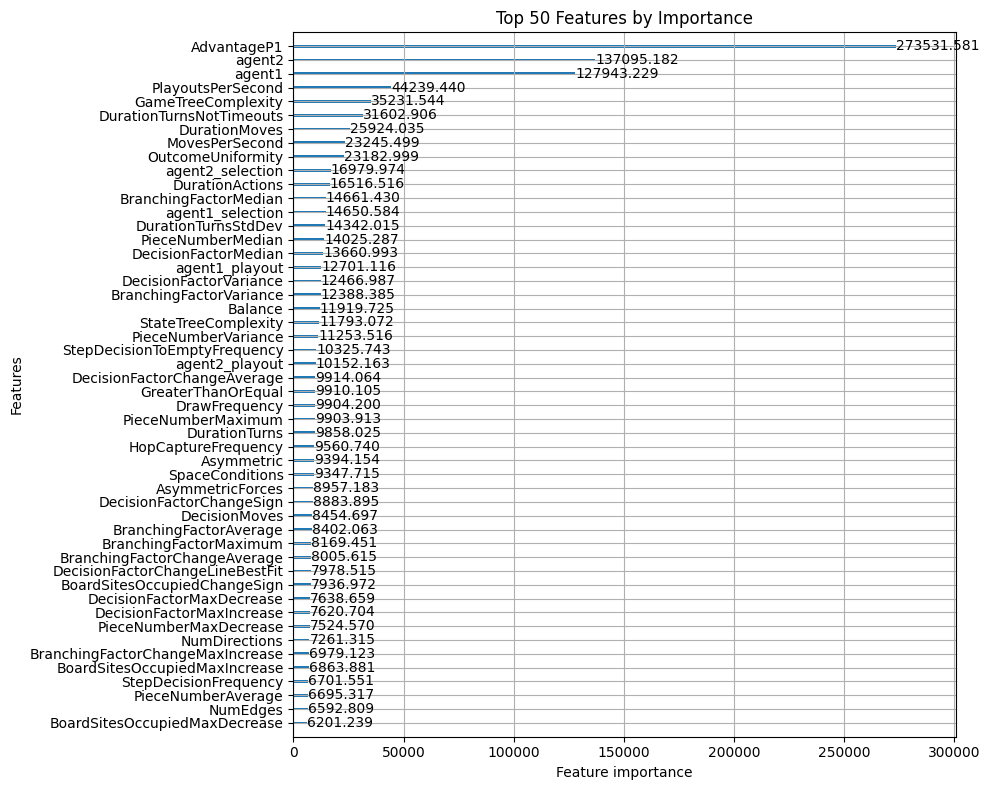

Fold 3 - RMSE: 0.4317170484314324
Fold 4


[100]	valid_0's rmse: 0.521174


[200]	valid_0's rmse: 0.495873


[300]	valid_0's rmse: 0.483589


[400]	valid_0's rmse: 0.475745


[500]	valid_0's rmse: 0.470596


[600]	valid_0's rmse: 0.466686


[700]	valid_0's rmse: 0.463232


[800]	valid_0's rmse: 0.460666


[900]	valid_0's rmse: 0.459166


[1000]	valid_0's rmse: 0.457433


[1100]	valid_0's rmse: 0.456336


[1200]	valid_0's rmse: 0.455387


[1300]	valid_0's rmse: 0.454086


[1400]	valid_0's rmse: 0.453224


[1500]	valid_0's rmse: 0.452242


[1600]	valid_0's rmse: 0.45153


[1700]	valid_0's rmse: 0.451082


[1800]	valid_0's rmse: 0.450522


[1900]	valid_0's rmse: 0.449838


[2000]	valid_0's rmse: 0.449338


[2100]	valid_0's rmse: 0.448955


[2200]	valid_0's rmse: 0.448588


[2300]	valid_0's rmse: 0.448252


[2400]	valid_0's rmse: 0.447832


[2500]	valid_0's rmse: 0.447485


[2600]	valid_0's rmse: 0.447236


[2700]	valid_0's rmse: 0.446949


[2800]	valid_0's rmse: 0.44661


[2900]	valid_0's rmse: 0.446305


[3000]	valid_0's rmse: 0.446066


[3100]	valid_0's rmse: 0.445796


[3200]	valid_0's rmse: 0.445753


[3300]	valid_0's rmse: 0.44555


[3400]	valid_0's rmse: 0.445497


[3500]	valid_0's rmse: 0.445251


[3600]	valid_0's rmse: 0.445017


[3700]	valid_0's rmse: 0.444856


[3800]	valid_0's rmse: 0.444648


[3900]	valid_0's rmse: 0.444504


[4000]	valid_0's rmse: 0.444376


[4100]	valid_0's rmse: 0.444245


[4200]	valid_0's rmse: 0.444128


[4300]	valid_0's rmse: 0.443845


[4400]	valid_0's rmse: 0.443682


[4500]	valid_0's rmse: 0.443661


[4600]	valid_0's rmse: 0.443507


[4700]	valid_0's rmse: 0.44334


[4800]	valid_0's rmse: 0.443306


[4900]	valid_0's rmse: 0.443134


[5000]	valid_0's rmse: 0.443041


[5100]	valid_0's rmse: 0.442959


[5200]	valid_0's rmse: 0.442912


[5300]	valid_0's rmse: 0.44276


[5400]	valid_0's rmse: 0.442688


[5500]	valid_0's rmse: 0.442607


[5600]	valid_0's rmse: 0.442557


[5700]	valid_0's rmse: 0.442434


[5800]	valid_0's rmse: 0.442413


[5900]	valid_0's rmse: 0.442356


[6000]	valid_0's rmse: 0.442243


[6100]	valid_0's rmse: 0.44217


[6200]	valid_0's rmse: 0.442142


[6300]	valid_0's rmse: 0.441965


[6400]	valid_0's rmse: 0.441898


[6500]	valid_0's rmse: 0.441821


[6600]	valid_0's rmse: 0.441724


[6700]	valid_0's rmse: 0.441705


[6800]	valid_0's rmse: 0.441667


[6900]	valid_0's rmse: 0.441593


[7000]	valid_0's rmse: 0.441602


[7100]	valid_0's rmse: 0.441473


[7200]	valid_0's rmse: 0.441472


[7300]	valid_0's rmse: 0.441365


[7400]	valid_0's rmse: 0.441399


[7500]	valid_0's rmse: 0.441376


[7600]	valid_0's rmse: 0.441337


[7700]	valid_0's rmse: 0.441286


[7800]	valid_0's rmse: 0.441246


[7900]	valid_0's rmse: 0.441194


[8000]	valid_0's rmse: 0.441152


[8100]	valid_0's rmse: 0.441126


[8200]	valid_0's rmse: 0.441063


[8300]	valid_0's rmse: 0.44112


[8400]	valid_0's rmse: 0.441051


[8500]	valid_0's rmse: 0.440975


[8600]	valid_0's rmse: 0.440935


[8700]	valid_0's rmse: 0.440971


[8800]	valid_0's rmse: 0.440954


[8900]	valid_0's rmse: 0.440861


[9000]	valid_0's rmse: 0.440898


[9100]	valid_0's rmse: 0.440796


[9200]	valid_0's rmse: 0.440747


[9300]	valid_0's rmse: 0.440735


[9400]	valid_0's rmse: 0.440717


[9500]	valid_0's rmse: 0.440756


[9600]	valid_0's rmse: 0.440726


[9700]	valid_0's rmse: 0.440692


[9800]	valid_0's rmse: 0.440711


[9900]	valid_0's rmse: 0.440717


[10000]	valid_0's rmse: 0.440716


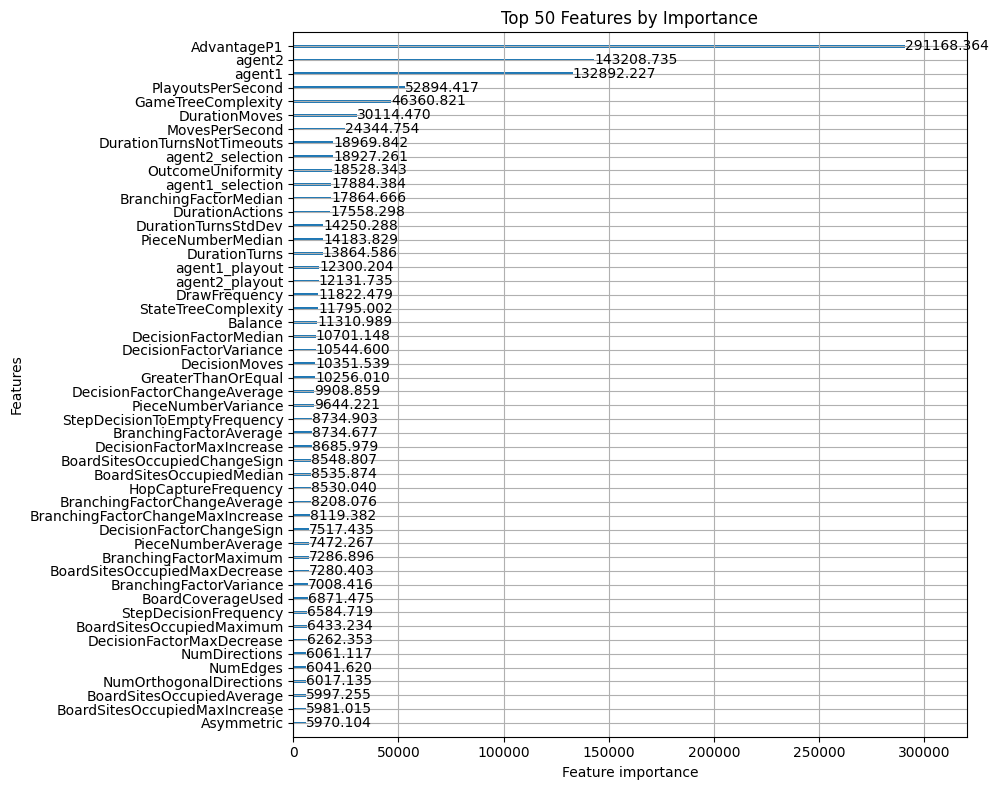

Fold 4 - RMSE: 0.44033834081872864
Fold 5


[100]	valid_0's rmse: 0.519125


[200]	valid_0's rmse: 0.496253


[300]	valid_0's rmse: 0.482366


[400]	valid_0's rmse: 0.4751


[500]	valid_0's rmse: 0.469793


[600]	valid_0's rmse: 0.465413


[700]	valid_0's rmse: 0.461579


[800]	valid_0's rmse: 0.4583


[900]	valid_0's rmse: 0.456041


[1000]	valid_0's rmse: 0.45451


[1100]	valid_0's rmse: 0.452693


[1200]	valid_0's rmse: 0.451227


[1300]	valid_0's rmse: 0.449842


[1400]	valid_0's rmse: 0.448776


[1500]	valid_0's rmse: 0.447744


[1600]	valid_0's rmse: 0.447103


[1700]	valid_0's rmse: 0.446348


[1800]	valid_0's rmse: 0.445514


[1900]	valid_0's rmse: 0.444779


[2000]	valid_0's rmse: 0.444287


[2100]	valid_0's rmse: 0.443629


[2200]	valid_0's rmse: 0.443167


[2300]	valid_0's rmse: 0.442711


[2400]	valid_0's rmse: 0.442213


[2500]	valid_0's rmse: 0.441708


[2600]	valid_0's rmse: 0.441449


[2700]	valid_0's rmse: 0.441026


[2800]	valid_0's rmse: 0.440672


[2900]	valid_0's rmse: 0.440544


[3000]	valid_0's rmse: 0.440227


[3100]	valid_0's rmse: 0.439847


[3200]	valid_0's rmse: 0.439596


[3300]	valid_0's rmse: 0.439383


[3400]	valid_0's rmse: 0.439237


[3500]	valid_0's rmse: 0.439087


[3600]	valid_0's rmse: 0.438765


[3700]	valid_0's rmse: 0.438655


[3800]	valid_0's rmse: 0.438465


[3900]	valid_0's rmse: 0.438221


[4000]	valid_0's rmse: 0.43808


[4100]	valid_0's rmse: 0.437954


[4200]	valid_0's rmse: 0.437804


[4300]	valid_0's rmse: 0.437634


[4400]	valid_0's rmse: 0.437463


[4500]	valid_0's rmse: 0.437288


[4600]	valid_0's rmse: 0.437174


[4700]	valid_0's rmse: 0.437065


[4800]	valid_0's rmse: 0.436992


[4900]	valid_0's rmse: 0.436887


[5000]	valid_0's rmse: 0.436798


[5100]	valid_0's rmse: 0.436721


[5200]	valid_0's rmse: 0.436568


[5300]	valid_0's rmse: 0.436507


[5400]	valid_0's rmse: 0.436325


[5500]	valid_0's rmse: 0.436301


[5600]	valid_0's rmse: 0.436259


[5700]	valid_0's rmse: 0.436146


[5800]	valid_0's rmse: 0.43606


[5900]	valid_0's rmse: 0.435966


[6000]	valid_0's rmse: 0.435956


[6100]	valid_0's rmse: 0.435853


[6200]	valid_0's rmse: 0.435738


[6300]	valid_0's rmse: 0.435687


[6400]	valid_0's rmse: 0.435618


[6500]	valid_0's rmse: 0.435578


[6600]	valid_0's rmse: 0.435576


[6700]	valid_0's rmse: 0.435532


[6800]	valid_0's rmse: 0.435478


[6900]	valid_0's rmse: 0.435428


[7000]	valid_0's rmse: 0.435363


[7100]	valid_0's rmse: 0.435357


[7200]	valid_0's rmse: 0.435288


[7300]	valid_0's rmse: 0.435175


[7400]	valid_0's rmse: 0.435124


[7500]	valid_0's rmse: 0.435134


[7600]	valid_0's rmse: 0.435095


[7700]	valid_0's rmse: 0.435095


[7800]	valid_0's rmse: 0.4351


[7900]	valid_0's rmse: 0.435068


[8000]	valid_0's rmse: 0.435


[8100]	valid_0's rmse: 0.435008


[8200]	valid_0's rmse: 0.43498


[8300]	valid_0's rmse: 0.434946


[8400]	valid_0's rmse: 0.434859


[8500]	valid_0's rmse: 0.434818


[8600]	valid_0's rmse: 0.434755


[8700]	valid_0's rmse: 0.434794


[8800]	valid_0's rmse: 0.434729


[8900]	valid_0's rmse: 0.434722


[9000]	valid_0's rmse: 0.434719


[9100]	valid_0's rmse: 0.434683


[9200]	valid_0's rmse: 0.434644


[9300]	valid_0's rmse: 0.434599


[9400]	valid_0's rmse: 0.434525


[9500]	valid_0's rmse: 0.434475


[9600]	valid_0's rmse: 0.434443


[9700]	valid_0's rmse: 0.43445


[9800]	valid_0's rmse: 0.434396


[9900]	valid_0's rmse: 0.43436


[10000]	valid_0's rmse: 0.434357


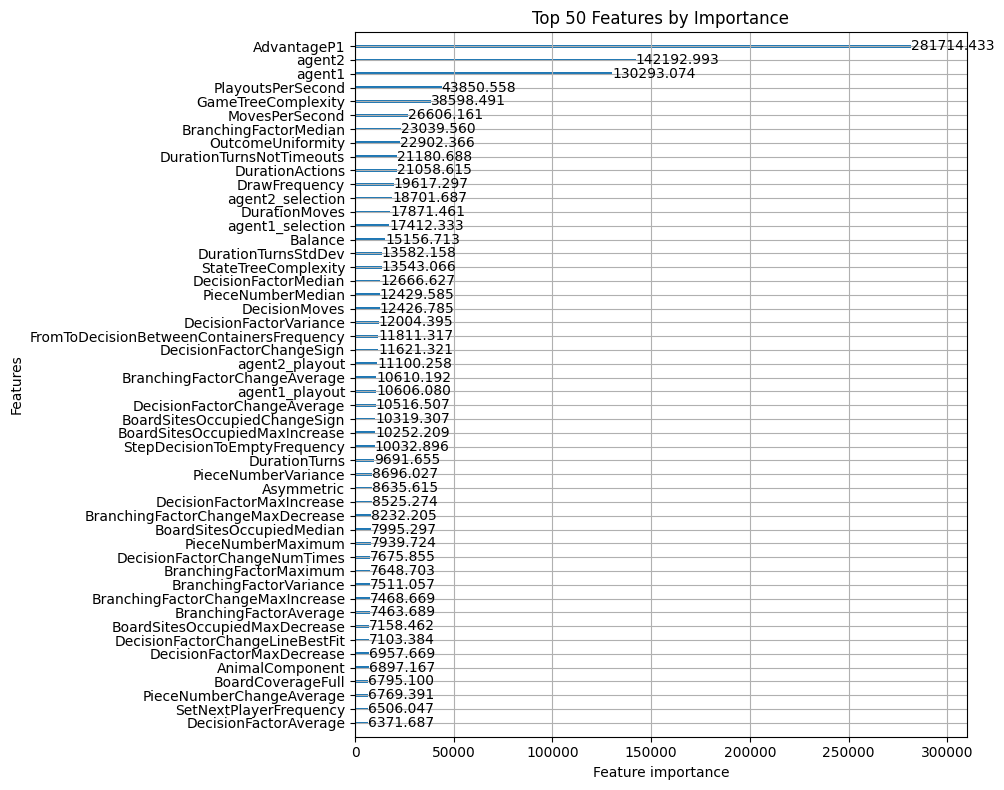

Fold 5 - RMSE: 0.4337194651446866
List of oof scores: [0.4093184258270123, 0.4011772206552318, 0.4317170484314324, 0.44033834081872864, 0.4337194651446866]
Average oof score: 0.42325410017541837


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv2.parquet', index=False)

Fold 1


[100]	valid_0's rmse: 0.508235


[200]	valid_0's rmse: 0.48591


[300]	valid_0's rmse: 0.473257


[400]	valid_0's rmse: 0.466483


[500]	valid_0's rmse: 0.460299


[600]	valid_0's rmse: 0.456039


[700]	valid_0's rmse: 0.453276


[800]	valid_0's rmse: 0.450963


[900]	valid_0's rmse: 0.449246


[1000]	valid_0's rmse: 0.448205


[1100]	valid_0's rmse: 0.447011


[1200]	valid_0's rmse: 0.445901


[1300]	valid_0's rmse: 0.444942


[1400]	valid_0's rmse: 0.444046


[1500]	valid_0's rmse: 0.443176


[1600]	valid_0's rmse: 0.442612


[1700]	valid_0's rmse: 0.442071


[1800]	valid_0's rmse: 0.441485


[1900]	valid_0's rmse: 0.440949


[2000]	valid_0's rmse: 0.440482


[2100]	valid_0's rmse: 0.439999


[2200]	valid_0's rmse: 0.439628


[2300]	valid_0's rmse: 0.439231


[2400]	valid_0's rmse: 0.438922


[2500]	valid_0's rmse: 0.438527


[2600]	valid_0's rmse: 0.438191


[2700]	valid_0's rmse: 0.437876


[2800]	valid_0's rmse: 0.437642


[2900]	valid_0's rmse: 0.437455


[3000]	valid_0's rmse: 0.437143


[3100]	valid_0's rmse: 0.436947


[3200]	valid_0's rmse: 0.436912


[3300]	valid_0's rmse: 0.436689


[3400]	valid_0's rmse: 0.436476


[3500]	valid_0's rmse: 0.436369


[3600]	valid_0's rmse: 0.436245


[3700]	valid_0's rmse: 0.436084


[3800]	valid_0's rmse: 0.436031


[3900]	valid_0's rmse: 0.435938


[4000]	valid_0's rmse: 0.435809


[4100]	valid_0's rmse: 0.435719


[4200]	valid_0's rmse: 0.435625


[4300]	valid_0's rmse: 0.435518


[4400]	valid_0's rmse: 0.43533


[4500]	valid_0's rmse: 0.435185


[4600]	valid_0's rmse: 0.435146


[4700]	valid_0's rmse: 0.435094


[4800]	valid_0's rmse: 0.435113


[4900]	valid_0's rmse: 0.434982


[5000]	valid_0's rmse: 0.434926


[5100]	valid_0's rmse: 0.43492


[5200]	valid_0's rmse: 0.43484


[5300]	valid_0's rmse: 0.434795


[5400]	valid_0's rmse: 0.434757


[5500]	valid_0's rmse: 0.43468


[5600]	valid_0's rmse: 0.434587


[5700]	valid_0's rmse: 0.434623


[5800]	valid_0's rmse: 0.434593


[5900]	valid_0's rmse: 0.434495


[6000]	valid_0's rmse: 0.434342


[6100]	valid_0's rmse: 0.434271


[6200]	valid_0's rmse: 0.434182


[6300]	valid_0's rmse: 0.43404


[6400]	valid_0's rmse: 0.434003


[6500]	valid_0's rmse: 0.433969


[6600]	valid_0's rmse: 0.433931


[6700]	valid_0's rmse: 0.433838


[6800]	valid_0's rmse: 0.433885


[6900]	valid_0's rmse: 0.433823


[7000]	valid_0's rmse: 0.433746


[7100]	valid_0's rmse: 0.433698


[7200]	valid_0's rmse: 0.433702


[7300]	valid_0's rmse: 0.433727


[7400]	valid_0's rmse: 0.433712


[7500]	valid_0's rmse: 0.433763


[7600]	valid_0's rmse: 0.433725


[7700]	valid_0's rmse: 0.433682


[7800]	valid_0's rmse: 0.433617


[7900]	valid_0's rmse: 0.433629


[8000]	valid_0's rmse: 0.433588


[8100]	valid_0's rmse: 0.433567


[8200]	valid_0's rmse: 0.433545


[8300]	valid_0's rmse: 0.433573


[8400]	valid_0's rmse: 0.43348


[8500]	valid_0's rmse: 0.433388


[8600]	valid_0's rmse: 0.433377


[8700]	valid_0's rmse: 0.433394


[8800]	valid_0's rmse: 0.433392


[8900]	valid_0's rmse: 0.433369


[9000]	valid_0's rmse: 0.433409


[9100]	valid_0's rmse: 0.43341


[9200]	valid_0's rmse: 0.433374


[9300]	valid_0's rmse: 0.433375


[9400]	valid_0's rmse: 0.433351


[9500]	valid_0's rmse: 0.433324


[9600]	valid_0's rmse: 0.433354


[9700]	valid_0's rmse: 0.433376


[9800]	valid_0's rmse: 0.433327


[9900]	valid_0's rmse: 0.433247


[10000]	valid_0's rmse: 0.433293


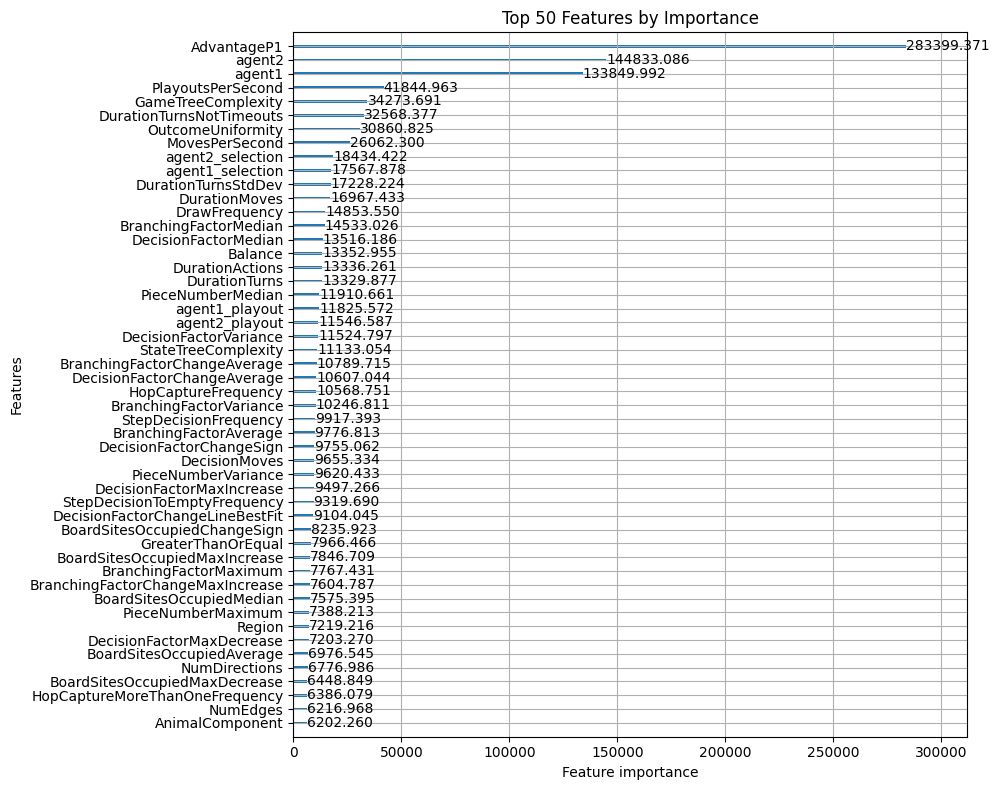

Fold 1 - RMSE: 0.4326606038775149
Fold 2


[100]	valid_0's rmse: 0.50431


[200]	valid_0's rmse: 0.480051


[300]	valid_0's rmse: 0.466611


[400]	valid_0's rmse: 0.457347


[500]	valid_0's rmse: 0.451191


[600]	valid_0's rmse: 0.44655


[700]	valid_0's rmse: 0.442862


[800]	valid_0's rmse: 0.440121


[900]	valid_0's rmse: 0.4378


[1000]	valid_0's rmse: 0.435968


[1100]	valid_0's rmse: 0.434292


[1200]	valid_0's rmse: 0.432768


[1300]	valid_0's rmse: 0.43147


[1400]	valid_0's rmse: 0.430315


[1500]	valid_0's rmse: 0.429175


[1600]	valid_0's rmse: 0.428316


[1700]	valid_0's rmse: 0.42751


[1800]	valid_0's rmse: 0.426714


[1900]	valid_0's rmse: 0.426015


[2000]	valid_0's rmse: 0.425449


[2100]	valid_0's rmse: 0.424995


[2200]	valid_0's rmse: 0.424333


[2300]	valid_0's rmse: 0.423856


[2400]	valid_0's rmse: 0.423432


[2500]	valid_0's rmse: 0.422935


[2600]	valid_0's rmse: 0.422469


[2700]	valid_0's rmse: 0.422081


[2800]	valid_0's rmse: 0.421699


[2900]	valid_0's rmse: 0.421321


[3000]	valid_0's rmse: 0.421069


[3100]	valid_0's rmse: 0.420697


[3200]	valid_0's rmse: 0.420427


[3300]	valid_0's rmse: 0.420128


[3400]	valid_0's rmse: 0.419933


[3500]	valid_0's rmse: 0.419742


[3600]	valid_0's rmse: 0.419452


[3700]	valid_0's rmse: 0.419278


[3800]	valid_0's rmse: 0.419155


[3900]	valid_0's rmse: 0.41884


[4000]	valid_0's rmse: 0.418713


[4100]	valid_0's rmse: 0.418489


[4200]	valid_0's rmse: 0.418365


[4300]	valid_0's rmse: 0.418228


[4400]	valid_0's rmse: 0.418046


[4500]	valid_0's rmse: 0.417883


[4600]	valid_0's rmse: 0.417834


[4700]	valid_0's rmse: 0.417662


[4800]	valid_0's rmse: 0.417552


[4900]	valid_0's rmse: 0.417517


[5000]	valid_0's rmse: 0.41745


[5100]	valid_0's rmse: 0.417323


[5200]	valid_0's rmse: 0.417115


[5300]	valid_0's rmse: 0.417095


[5400]	valid_0's rmse: 0.417034


[5500]	valid_0's rmse: 0.417031


[5600]	valid_0's rmse: 0.416988


[5700]	valid_0's rmse: 0.416898


[5800]	valid_0's rmse: 0.416851


[5900]	valid_0's rmse: 0.416733


[6000]	valid_0's rmse: 0.416637


[6100]	valid_0's rmse: 0.416569


[6200]	valid_0's rmse: 0.416533


[6300]	valid_0's rmse: 0.416553


[6400]	valid_0's rmse: 0.41648


[6500]	valid_0's rmse: 0.416391


[6600]	valid_0's rmse: 0.41633


[6700]	valid_0's rmse: 0.416316


[6800]	valid_0's rmse: 0.416246


[6900]	valid_0's rmse: 0.416241


[7000]	valid_0's rmse: 0.416184


[7100]	valid_0's rmse: 0.416097


[7200]	valid_0's rmse: 0.41603


[7300]	valid_0's rmse: 0.415909


[7400]	valid_0's rmse: 0.415823


[7500]	valid_0's rmse: 0.415771


[7600]	valid_0's rmse: 0.415664


[7700]	valid_0's rmse: 0.415675


[7800]	valid_0's rmse: 0.415676


[7900]	valid_0's rmse: 0.415693


[8000]	valid_0's rmse: 0.41565


[8100]	valid_0's rmse: 0.415648


[8200]	valid_0's rmse: 0.415623


[8300]	valid_0's rmse: 0.415549


[8400]	valid_0's rmse: 0.415493


[8500]	valid_0's rmse: 0.415468


[8600]	valid_0's rmse: 0.415444


[8700]	valid_0's rmse: 0.415378


[8800]	valid_0's rmse: 0.415393


[8900]	valid_0's rmse: 0.415368


[9000]	valid_0's rmse: 0.415301


[9100]	valid_0's rmse: 0.415293


[9200]	valid_0's rmse: 0.41531


[9300]	valid_0's rmse: 0.415288


[9400]	valid_0's rmse: 0.415248


[9500]	valid_0's rmse: 0.415189


[9600]	valid_0's rmse: 0.415154


[9700]	valid_0's rmse: 0.415136


[9800]	valid_0's rmse: 0.415182


[9900]	valid_0's rmse: 0.415195


[10000]	valid_0's rmse: 0.415169


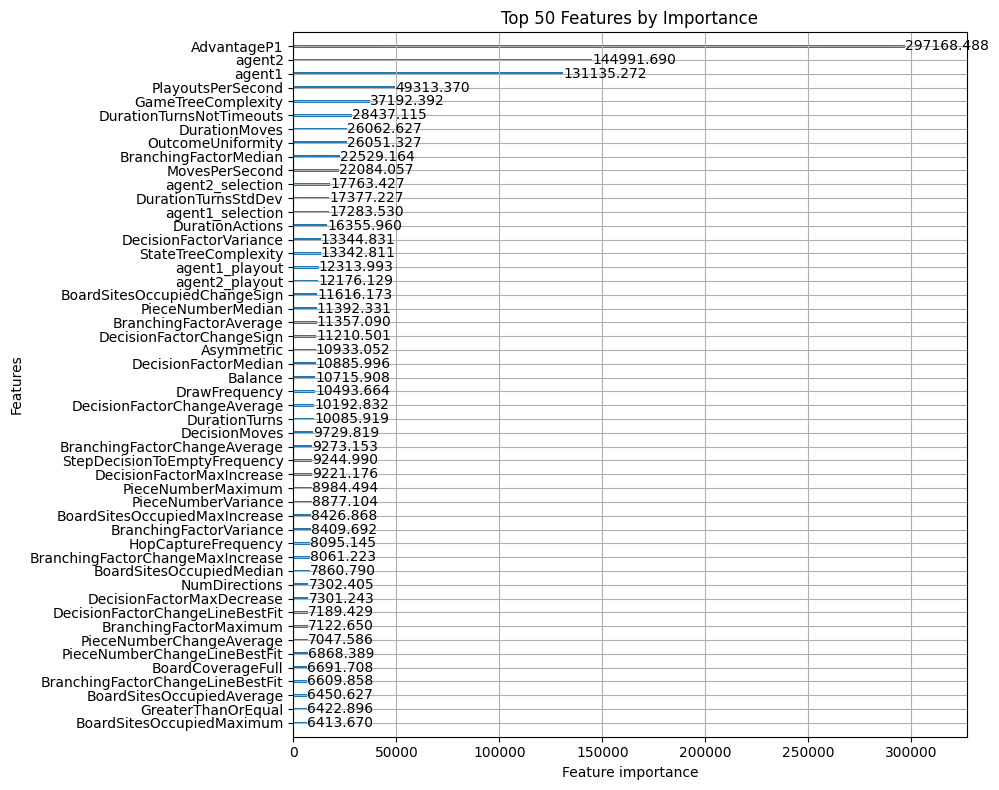

Fold 2 - RMSE: 0.41475303323430085
Fold 3


[100]	valid_0's rmse: 0.49563


[200]	valid_0's rmse: 0.47239


[300]	valid_0's rmse: 0.459522


[400]	valid_0's rmse: 0.452057


[500]	valid_0's rmse: 0.447752


[600]	valid_0's rmse: 0.444839


[700]	valid_0's rmse: 0.442268


[800]	valid_0's rmse: 0.440163


[900]	valid_0's rmse: 0.438438


[1000]	valid_0's rmse: 0.437486


[1100]	valid_0's rmse: 0.436163


[1200]	valid_0's rmse: 0.435013


[1300]	valid_0's rmse: 0.433728


[1400]	valid_0's rmse: 0.432911


[1500]	valid_0's rmse: 0.432264


[1600]	valid_0's rmse: 0.431711


[1700]	valid_0's rmse: 0.430839


[1800]	valid_0's rmse: 0.430467


[1900]	valid_0's rmse: 0.429895


[2000]	valid_0's rmse: 0.429379


[2100]	valid_0's rmse: 0.428963


[2200]	valid_0's rmse: 0.428715


[2300]	valid_0's rmse: 0.428294


[2400]	valid_0's rmse: 0.427955


[2500]	valid_0's rmse: 0.427555


[2600]	valid_0's rmse: 0.427256


[2700]	valid_0's rmse: 0.426839


[2800]	valid_0's rmse: 0.426735


[2900]	valid_0's rmse: 0.426543


[3000]	valid_0's rmse: 0.426412


[3100]	valid_0's rmse: 0.426236


[3200]	valid_0's rmse: 0.426112


[3300]	valid_0's rmse: 0.425899


[3400]	valid_0's rmse: 0.425724


[3500]	valid_0's rmse: 0.425492


[3600]	valid_0's rmse: 0.425403


[3700]	valid_0's rmse: 0.425235


[3800]	valid_0's rmse: 0.425038


[3900]	valid_0's rmse: 0.424839


[4000]	valid_0's rmse: 0.424741


[4100]	valid_0's rmse: 0.424688


[4200]	valid_0's rmse: 0.424588


[4300]	valid_0's rmse: 0.424659


[4400]	valid_0's rmse: 0.424563


[4500]	valid_0's rmse: 0.424491


[4600]	valid_0's rmse: 0.424331


[4700]	valid_0's rmse: 0.424208


[4800]	valid_0's rmse: 0.424129


[4900]	valid_0's rmse: 0.424049


[5000]	valid_0's rmse: 0.423907


[5100]	valid_0's rmse: 0.423885


[5200]	valid_0's rmse: 0.423701


[5300]	valid_0's rmse: 0.42354


[5400]	valid_0's rmse: 0.423452


[5500]	valid_0's rmse: 0.423339


[5600]	valid_0's rmse: 0.423288


[5700]	valid_0's rmse: 0.423141


[5800]	valid_0's rmse: 0.423105


[5900]	valid_0's rmse: 0.423033


[6000]	valid_0's rmse: 0.422982


[6100]	valid_0's rmse: 0.422959


[6200]	valid_0's rmse: 0.42293


[6300]	valid_0's rmse: 0.422888


[6400]	valid_0's rmse: 0.422853


[6500]	valid_0's rmse: 0.42283


[6600]	valid_0's rmse: 0.422754


[6700]	valid_0's rmse: 0.422771


[6800]	valid_0's rmse: 0.42268


[6900]	valid_0's rmse: 0.422635


[7000]	valid_0's rmse: 0.422673


[7100]	valid_0's rmse: 0.422673


[7200]	valid_0's rmse: 0.42267


[7300]	valid_0's rmse: 0.422584


[7400]	valid_0's rmse: 0.422508


[7500]	valid_0's rmse: 0.422532


[7600]	valid_0's rmse: 0.422382


[7700]	valid_0's rmse: 0.422356


[7800]	valid_0's rmse: 0.422387


[7900]	valid_0's rmse: 0.422334


[8000]	valid_0's rmse: 0.422282


[8100]	valid_0's rmse: 0.422272


[8200]	valid_0's rmse: 0.422271


[8300]	valid_0's rmse: 0.422261


[8400]	valid_0's rmse: 0.422289


[8500]	valid_0's rmse: 0.422222


[8600]	valid_0's rmse: 0.422233


[8700]	valid_0's rmse: 0.422171


[8800]	valid_0's rmse: 0.42212


[8900]	valid_0's rmse: 0.422161


[9000]	valid_0's rmse: 0.422131


[9100]	valid_0's rmse: 0.422137


[9200]	valid_0's rmse: 0.422114


[9300]	valid_0's rmse: 0.422082


[9400]	valid_0's rmse: 0.422054


[9500]	valid_0's rmse: 0.42205


[9600]	valid_0's rmse: 0.422078


[9700]	valid_0's rmse: 0.42203


[9800]	valid_0's rmse: 0.421965


[9900]	valid_0's rmse: 0.421954


[10000]	valid_0's rmse: 0.421941


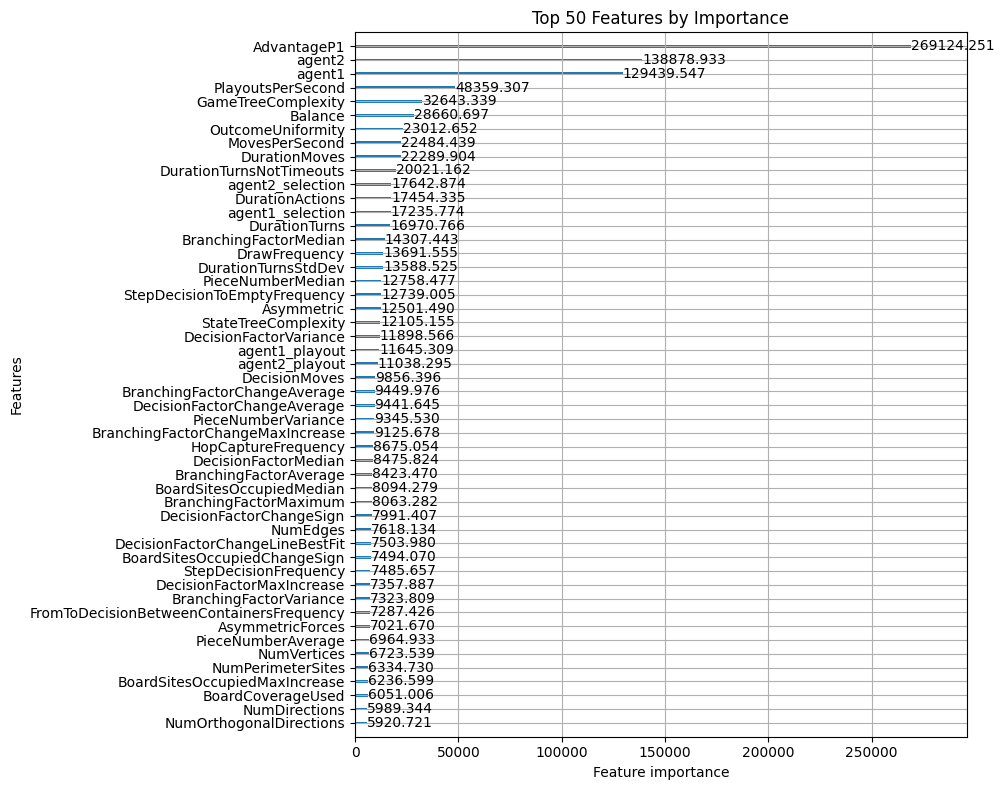

Fold 3 - RMSE: 0.42139849983353334
Fold 4


[100]	valid_0's rmse: 0.489272


[200]	valid_0's rmse: 0.467883


[300]	valid_0's rmse: 0.456495


[400]	valid_0's rmse: 0.44962


[500]	valid_0's rmse: 0.444849


[600]	valid_0's rmse: 0.441032


[700]	valid_0's rmse: 0.437905


[800]	valid_0's rmse: 0.435702


[900]	valid_0's rmse: 0.433714


[1000]	valid_0's rmse: 0.43252


[1100]	valid_0's rmse: 0.431335


[1200]	valid_0's rmse: 0.430362


[1300]	valid_0's rmse: 0.429325


[1400]	valid_0's rmse: 0.428455


[1500]	valid_0's rmse: 0.427644


[1600]	valid_0's rmse: 0.427036


[1700]	valid_0's rmse: 0.426526


[1800]	valid_0's rmse: 0.426107


[1900]	valid_0's rmse: 0.425591


[2000]	valid_0's rmse: 0.425235


[2100]	valid_0's rmse: 0.424849


[2200]	valid_0's rmse: 0.424368


[2300]	valid_0's rmse: 0.424098


[2400]	valid_0's rmse: 0.423775


[2500]	valid_0's rmse: 0.423401


[2600]	valid_0's rmse: 0.423019


[2700]	valid_0's rmse: 0.422817


[2800]	valid_0's rmse: 0.422631


[2900]	valid_0's rmse: 0.422463


[3000]	valid_0's rmse: 0.422238


[3100]	valid_0's rmse: 0.422056


[3200]	valid_0's rmse: 0.421884


[3300]	valid_0's rmse: 0.421672


[3400]	valid_0's rmse: 0.42147


[3500]	valid_0's rmse: 0.421333


[3600]	valid_0's rmse: 0.421097


[3700]	valid_0's rmse: 0.42098


[3800]	valid_0's rmse: 0.420753


[3900]	valid_0's rmse: 0.420716


[4000]	valid_0's rmse: 0.420556


[4100]	valid_0's rmse: 0.420444


[4200]	valid_0's rmse: 0.420311


[4300]	valid_0's rmse: 0.420268


[4400]	valid_0's rmse: 0.420113


[4500]	valid_0's rmse: 0.419914


[4600]	valid_0's rmse: 0.419848


[4700]	valid_0's rmse: 0.419744


[4800]	valid_0's rmse: 0.419681


[4900]	valid_0's rmse: 0.419613


[5000]	valid_0's rmse: 0.419592


[5100]	valid_0's rmse: 0.41944


[5200]	valid_0's rmse: 0.419309


[5300]	valid_0's rmse: 0.419206


[5400]	valid_0's rmse: 0.419077


[5500]	valid_0's rmse: 0.419041


[5600]	valid_0's rmse: 0.419012


[5700]	valid_0's rmse: 0.418912


[5800]	valid_0's rmse: 0.418833


[5900]	valid_0's rmse: 0.418748


[6000]	valid_0's rmse: 0.418762


[6100]	valid_0's rmse: 0.418708


[6200]	valid_0's rmse: 0.418664


[6300]	valid_0's rmse: 0.41862


[6400]	valid_0's rmse: 0.418559


[6500]	valid_0's rmse: 0.418517


[6600]	valid_0's rmse: 0.418527


[6700]	valid_0's rmse: 0.418449


[6800]	valid_0's rmse: 0.41837


[6900]	valid_0's rmse: 0.418317


[7000]	valid_0's rmse: 0.418278


[7100]	valid_0's rmse: 0.418256


[7200]	valid_0's rmse: 0.418243


[7300]	valid_0's rmse: 0.418246


[7400]	valid_0's rmse: 0.418205


[7500]	valid_0's rmse: 0.418235


[7600]	valid_0's rmse: 0.418268


[7700]	valid_0's rmse: 0.41823


[7800]	valid_0's rmse: 0.418177


[7900]	valid_0's rmse: 0.41815


[8000]	valid_0's rmse: 0.418195


[8100]	valid_0's rmse: 0.418186


[8200]	valid_0's rmse: 0.418124


[8300]	valid_0's rmse: 0.418089


[8400]	valid_0's rmse: 0.417979


[8500]	valid_0's rmse: 0.417919


[8600]	valid_0's rmse: 0.417943


[8700]	valid_0's rmse: 0.417897


[8800]	valid_0's rmse: 0.4179


[8900]	valid_0's rmse: 0.41791


[9000]	valid_0's rmse: 0.417901


[9100]	valid_0's rmse: 0.41788


[9200]	valid_0's rmse: 0.417878


[9300]	valid_0's rmse: 0.417827


[9400]	valid_0's rmse: 0.417806


[9500]	valid_0's rmse: 0.417754


[9600]	valid_0's rmse: 0.417731


[9700]	valid_0's rmse: 0.417658


[9800]	valid_0's rmse: 0.417684


[9900]	valid_0's rmse: 0.417643


[10000]	valid_0's rmse: 0.417654


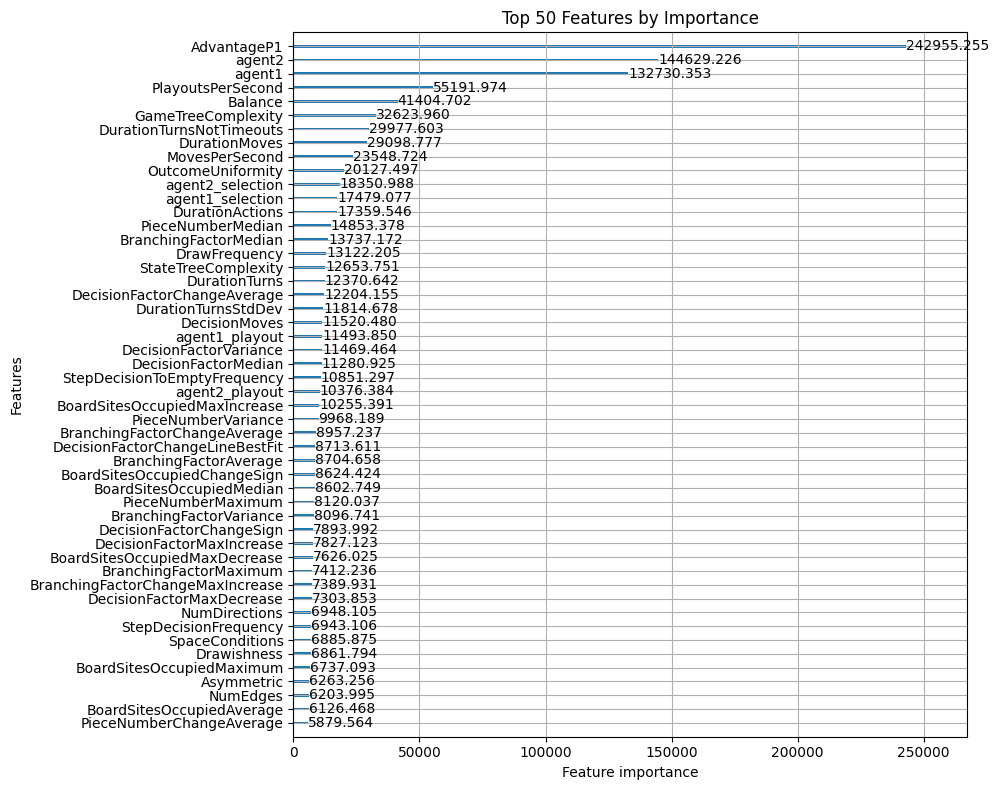

Fold 4 - RMSE: 0.4170120721644212
Fold 5


[100]	valid_0's rmse: 0.511075


[200]	valid_0's rmse: 0.491522


[300]	valid_0's rmse: 0.47981


[400]	valid_0's rmse: 0.471779


[500]	valid_0's rmse: 0.466033


[600]	valid_0's rmse: 0.461383


[700]	valid_0's rmse: 0.457815


[800]	valid_0's rmse: 0.45466


[900]	valid_0's rmse: 0.452345


[1000]	valid_0's rmse: 0.450164


[1100]	valid_0's rmse: 0.448503


[1200]	valid_0's rmse: 0.447249


[1300]	valid_0's rmse: 0.446095


[1400]	valid_0's rmse: 0.44488


[1500]	valid_0's rmse: 0.443981


[1600]	valid_0's rmse: 0.44293


[1700]	valid_0's rmse: 0.442152


[1800]	valid_0's rmse: 0.44139


[1900]	valid_0's rmse: 0.440755


[2000]	valid_0's rmse: 0.440196


[2100]	valid_0's rmse: 0.43964


[2200]	valid_0's rmse: 0.43911


[2300]	valid_0's rmse: 0.438537


[2400]	valid_0's rmse: 0.438049


[2500]	valid_0's rmse: 0.43756


[2600]	valid_0's rmse: 0.437212


[2700]	valid_0's rmse: 0.436843


[2800]	valid_0's rmse: 0.436419


[2900]	valid_0's rmse: 0.43612


[3000]	valid_0's rmse: 0.43588


[3100]	valid_0's rmse: 0.435565


[3200]	valid_0's rmse: 0.435318


[3300]	valid_0's rmse: 0.43502


[3400]	valid_0's rmse: 0.434809


[3500]	valid_0's rmse: 0.434611


[3600]	valid_0's rmse: 0.434465


[3700]	valid_0's rmse: 0.434267


[3800]	valid_0's rmse: 0.434061


[3900]	valid_0's rmse: 0.433856


[4000]	valid_0's rmse: 0.433583


[4100]	valid_0's rmse: 0.433385


[4200]	valid_0's rmse: 0.433162


[4300]	valid_0's rmse: 0.433008


[4400]	valid_0's rmse: 0.432858


[4500]	valid_0's rmse: 0.432667


[4600]	valid_0's rmse: 0.4325


[4700]	valid_0's rmse: 0.432416


[4800]	valid_0's rmse: 0.432381


[4900]	valid_0's rmse: 0.432268


[5000]	valid_0's rmse: 0.432155


[5100]	valid_0's rmse: 0.432048


[5200]	valid_0's rmse: 0.431922


[5300]	valid_0's rmse: 0.431783


[5400]	valid_0's rmse: 0.431674


[5500]	valid_0's rmse: 0.431573


[5600]	valid_0's rmse: 0.431507


[5700]	valid_0's rmse: 0.431452


[5800]	valid_0's rmse: 0.431371


[5900]	valid_0's rmse: 0.431287


[6000]	valid_0's rmse: 0.43122


[6100]	valid_0's rmse: 0.431163


[6200]	valid_0's rmse: 0.431104


[6300]	valid_0's rmse: 0.431007


[6400]	valid_0's rmse: 0.430927


[6500]	valid_0's rmse: 0.430844


[6600]	valid_0's rmse: 0.430749


[6700]	valid_0's rmse: 0.430714


[6800]	valid_0's rmse: 0.43072


[6900]	valid_0's rmse: 0.430694


[7000]	valid_0's rmse: 0.430729


[7100]	valid_0's rmse: 0.430712


[7200]	valid_0's rmse: 0.430575


[7300]	valid_0's rmse: 0.430544


[7400]	valid_0's rmse: 0.43048


[7500]	valid_0's rmse: 0.430464


[7600]	valid_0's rmse: 0.430466


[7700]	valid_0's rmse: 0.430451


[7800]	valid_0's rmse: 0.430367


[7900]	valid_0's rmse: 0.430272


[8000]	valid_0's rmse: 0.430199


[8100]	valid_0's rmse: 0.430186


[8200]	valid_0's rmse: 0.430176


[8300]	valid_0's rmse: 0.43017


[8400]	valid_0's rmse: 0.43017


[8500]	valid_0's rmse: 0.430039


[8600]	valid_0's rmse: 0.430099


[8700]	valid_0's rmse: 0.430064


[8800]	valid_0's rmse: 0.429951


[8900]	valid_0's rmse: 0.429887


[9000]	valid_0's rmse: 0.42992


[9100]	valid_0's rmse: 0.429815


[9200]	valid_0's rmse: 0.429766


[9300]	valid_0's rmse: 0.429789


[9400]	valid_0's rmse: 0.42985


[9500]	valid_0's rmse: 0.429789


[9600]	valid_0's rmse: 0.429758


[9700]	valid_0's rmse: 0.429696


[9800]	valid_0's rmse: 0.429692


[9900]	valid_0's rmse: 0.429665


[10000]	valid_0's rmse: 0.429656


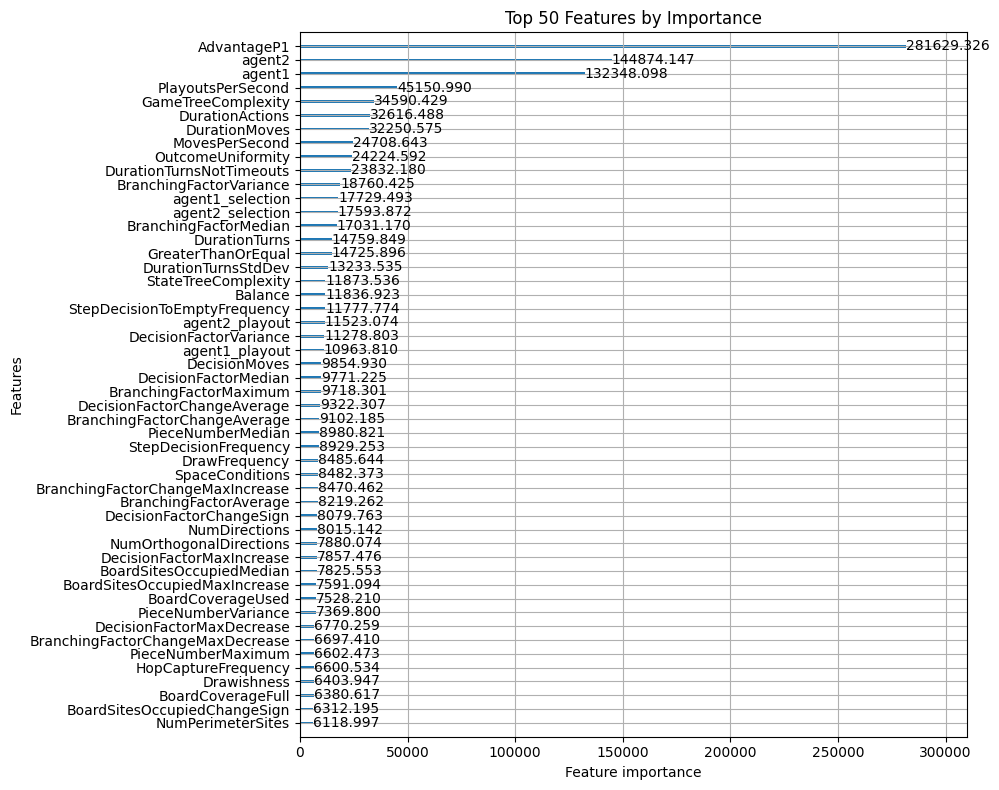

Fold 5 - RMSE: 0.42900609440793075
List of oof scores: [0.4326606038775149, 0.41475303323430085, 0.42139849983353334, 0.4170120721644212, 0.42900609440793075]
Average oof score: 0.42296606070354026


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv3.parquet', index=False)

In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")

CV1 OOF Scores:
Score: 0.4235
Score: 0.4474
Score: 0.4369
Score: 0.4360
Score: 0.4061
Average CV1 Score: 0.4300

CV2 OOF Scores:
Score: 0.4093
Score: 0.4012
Score: 0.4317
Score: 0.4403
Score: 0.4337
Average CV2 Score: 0.4233

CV3 OOF Scores:
Score: 0.4327
Score: 0.4148
Score: 0.4214
Score: 0.4170
Score: 0.4290
Average CV3 Score: 0.4230


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

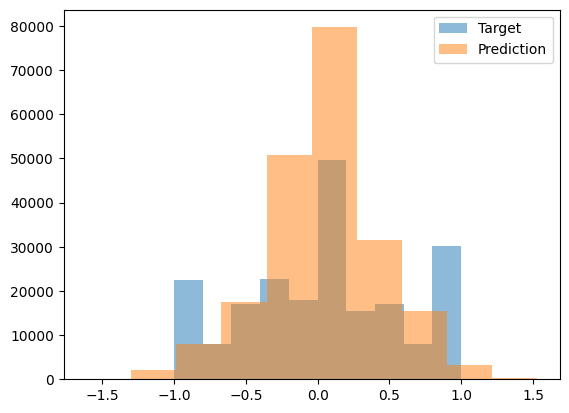

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame,):   
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Average predictions from all models
    predictions = [
        model.predict(test_processed[numerical_cols + categorical_cols]) 
        for model in trained_models
    ]
    predictions = np.mean(predictions, axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

shape: (3, 2)
┌────────┬────────────────┐
│ Id     ┆ utility_agent1 │
│ ---    ┆ ---            │
│ i64    ┆ f64            │
╞════════╪════════════════╡
│ 233234 ┆ 0.150933       │
│ 233235 ┆ -0.209682      │
│ 233236 ┆ -0.002705      │
└────────┴────────────────┘

In [20]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [21]:
# Save all artifacts needed for prediction
lightgbm_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols, 
    'encoder': encoder,
    'scaler': scaler
}

with open(f'./lightgbm_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(lightgbm_predict, f)

***